# **Unsupervised Learning: Credit Card Fraud Detection**

This notebook demonstrates unsupervised learning techniques including K-Means and K-Medoids clustering for image segmentation, and anomaly detection using Isolation Forest and Local Outlier Factor for fraud detection.

---

## Required Libraries

**Note:** The libraries below are required for this analysis.

In [2]:
import sys
!{sys.executable} -m pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import sys
!{sys.executable} -m pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [4]:
import numpy as np              # For numerical operations and array manipulations
import matplotlib.pyplot as plt # For plotting and visualization
import pandas as pd             # For data handling and CSV file reading
from sklearn.preprocessing import StandardScaler  # For feature scaling
from sklearn.metrics import precision_score, recall_score, f1_score, silhouette_score  # For evaluation metrics
from sklearn.decomposition import PCA  # For dimensionality reduction (PCA for visualization)
import requests                 # For downloading images or data from URLs (used in Tasks 1 and 2)
from io import BytesIO          # For handling binary data streams (used with requests)
from PIL import Image           # For image processing (used in Tasks 1 and 2)
import cv2                      # For computer vision tasks
from sklearn.manifold import TSNE #Again useful for NL dimensionality reduction
import seaborn as sns


## **Part 1:** Image Segmentation with Clustering (- marks)

**Objective:** This task explores the application of unsupervised clustering techniques to partition an image into meaningful regions based on pixel similarities. By implementing algorithms like K-means and K-medoids, you will investigate how to automatically segment visual data, which is crucial for tasks like object recognition and image editing, offering a foundation for understanding pattern recognition in computer vision.

In [5]:
#DO NOT CHANGE THIS CELL

url = "https://media.wired.com/photos/5b7c67dff521ce3ac9ba45e9/16:9/w_2240,h_1260,c_limit/post10%5Bhttps-_goo.gl_maps_g65Rg5BDBsQ2%5D-(1).jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img = np.array(img)

img_resized = np.array(Image.fromarray(img).resize((100, 100)))
height, width, _ = img_resized.shape
pixels = img_resized.reshape(-1, 3).astype(float) / 255.0  # normalize

def rgb_to_ycbcr(rgb):
    r, g, b = rgb[:, 0], rgb[:, 1], rgb[:, 2]
    y = 0.299 * r + 0.587 * g + 0.114 * b
    cb = 0.5 * b - 0.1687 * r - 0.3313 * g + 0.5
    cr = 0.5 * r - 0.4187 * g - 0.0813 * b + 0.5
    return np.column_stack((y, cb, cr))

pixels_ycbcr = rgb_to_ycbcr(pixels)

features = pixels_ycbcr

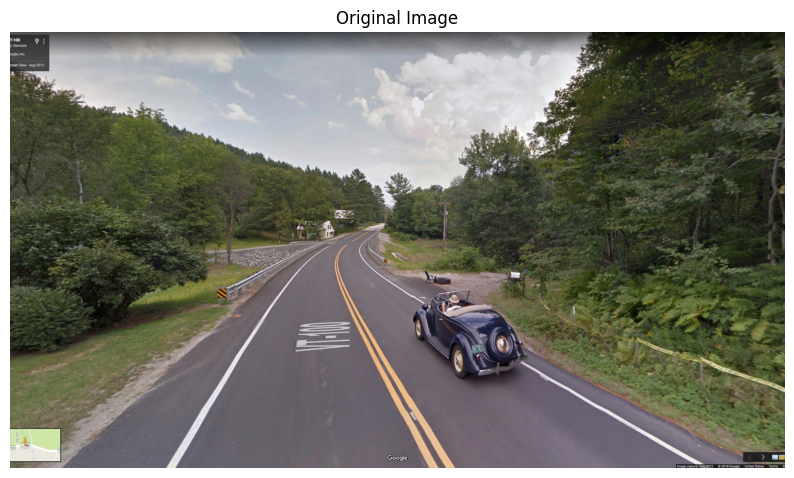

In [6]:
#DO NOT CHANGE THIS CELL

plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')
plt.show()

<span style="color: purple; font-size: 20px;">**Task 1.1:**</span>

In this task, you will implement clustering algorithms to group data points based on their features. Your goal is to create functions for initializing and performing two popular clustering techniques. Follow these steps to complete the task:

-  Implement a smart **initialization method for K-means clustering** that selects initial centroids to improve convergence.
-  Develop the **K-means algorithm**, allowing for a custom initialization option to enhance clustering efficiency.
-  Create a **K-medoids algorithm**, which uses actual data points as cluster representatives instead of means, focusing on robustness to outliers.
-  Use NumPy for efficient vectorized operations to assign points to clusters and update centroids or medoids.

Hint: Pay attention to the iteration logic and convergence checks in each algorithm. Start by understanding how distances are calculated and minimized to form clusters.

In [8]:
X = features
m, n = X.shape
m,n

(10000, 3)

In [9]:
import pandas as pd
features_df = pd.DataFrame(features)
features_df.head()


0         1         2
0  0.249851  0.500638  0.503603
1  0.257694  0.500638  0.503603
2  0.263918  0.499338  0.501961
3  0.254902  0.500000  0.500000
4  0.262745  0.500000  0.500000

In [11]:

m, n = X.shape

centroids = np.zeros((5, n))
distances = np.full(n, np.inf)
distances.shape

(3,)

In [12]:
centroids = X[np.random.choice(m, 5, replace=False)]
centroids

array([[0.14399216, 0.48955843, 0.49799137],
       [0.39597647, 0.49784784, 0.54482706],
       [0.17411373, 0.46149373, 0.49328863],
       [0.39140784, 0.42296353, 0.49214078],
       [0.15265098, 0.46475373, 0.49461176]])

In [13]:
m, n = X.shape
medoids_idx = np.random.choice(m, 5, replace=False)
medoids = X[medoids_idx]
medoids_idx, medoids

(array([7122, 8428, 3741, 4726, 6996]),
 array([[0.51761569, 0.4646102 , 0.52799294],
        [0.3859098 , 0.51237843, 0.50725333],
        [0.3016549 , 0.44705882, 0.50860824],
        [0.21337255, 0.4614698 , 0.49885216],
        [0.50320392, 0.39085765, 0.51589333]]))

In [14]:
X[[8987, 4124, 7074, 7241, 3328]]

array([[0.49170588, 0.43718314, 0.52689294],
       [0.22682353, 0.45166588, 0.50044627],
       [0.3535098 , 0.4399251 , 0.49679569],
       [0.57438039, 0.50781922, 0.50428824],
       [0.30001176, 0.45683882, 0.51257765]])

In [15]:
def sq_dists(X, centroids):
    per_centroid = [np.sum((X - c)**2, axis=1) for c in centroids]
    return np.stack(per_centroid, axis=1)

In [16]:
def euclidean_distance_matrix(X, squared=False):
    X = np.asarray(X, dtype=np.float64)
    Xn = (X**2).sum(axis=1)[:, None]
    D2 = Xn + Xn.T - 2.0 * (X @ X.T)
    np.maximum(D2, 0.0, out=D2) 
    return D2 if squared else np.sqrt(D2)

In [17]:
euclidean_distance_matrix(X[:5])

array([[0.        , 0.00784314, 0.01422164, 0.00623689, 0.01340316],
       [0.00784314, 0.        , 0.0065663 , 0.00460245, 0.00623689],
       [0.01422164, 0.0065663 , 0.        , 0.00925013, 0.00237849],
       [0.00623689, 0.00460245, 0.00925013, 0.        , 0.00784314],
       [0.01340316, 0.00623689, 0.00237849, 0.00784314, 0.        ]])

In [18]:
m, n = X.shape
medoids_idx = np.random.choice(m, 5, replace=False)

D = euclidean_distance_matrix(X)
labels = np.argmin(D[:, medoids_idx], axis=1)
labels

array([1, 1, 1, ..., 1, 4, 1], shape=(10000,))

In [19]:
k = len(medoids_idx)

# what labels did we get?
uniq, counts = np.unique(labels, return_counts=True)
print("Unique labels:", uniq)
print("Counts per label:", dict(zip(uniq, counts)))

# did we use all k clusters?
expected = set(range(k))
found = set(uniq)
missing = sorted(expected - found)
if missing:
    print("Missing clusters:", missing)
else:
    print("All clusters present.")

Unique labels: [0 1 2 3 4]
Counts per label: {np.int64(0): np.int64(1376), np.int64(1): np.int64(2023), np.int64(2): np.int64(2240), np.int64(3): np.int64(2642), np.int64(4): np.int64(1719)}
All clusters present.


In [20]:
np.where(labels == 1)

(array([   0,    1,    2, ..., 9994, 9997, 9999], shape=(2023,)),)

In [21]:
np.linalg.norm??

Signature:       np.linalg.norm(x, ord=None, axis=None, keepdims=False)
Call signature:  np.linalg.norm(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function norm at 0x1091b3240>
File:            /opt/miniconda3/lib/python3.13/site-packages/numpy/linalg/_linalg.py
Source:         
@array_function_dispatch(_norm_dispatcher)
def norm(x, ord=None, axis=None, keepdims=False):
    """
    Matrix or vector norm.

    This function is able to return one of eight different matrix norms,
    or one of an infinite number of vector norms (described below), depending
    on the value of the ``ord`` parameter.

    Parameters
    ----------
    x : array_like
        Input array.  If `axis` is None, `x` must be 1-D or 2-D, unless `ord`
        is None. If both `axis` and `ord` are None, the 2-norm of
        ``x.ravel`` will be returned.
    ord : {int, float, inf, -inf, 'fro', 'nuc'}, optional
        Order of the norm (see table under ``Notes`` for what values are


In [22]:
def kmeanspp_init(X, k):
    m, n = X.shape
    centroids = np.empty((k, n), dtype=X.dtype)

    row_0 = np.random.randint(m)
    centroids[0] = X[row_0]

    #YOUR CODE HERE
    
    chosen = {row_0}
    distances = np.linalg.norm(X - centroids[0], axis=1)**2

    for c in range(1, k):
        total = float(distances.sum())

        if total == 0.0:
            remaining = list(set(range(m)) - chosen)
            chosen_idx = np.random.choice(remaining)
        else:
            probabilities = distances / total
            chosen_idx = np.random.choice(m, p=probabilities)
            while chosen_idx in chosen and len(chosen) < m:
                chosen_idx = np.random.choice(m, p=probabilities)

        centroids[c] = X[chosen_idx]
        chosen.add(chosen_idx)

        d2_new = np.linalg.norm(X - centroids[c], axis=1)**2
        distances = np.minimum(distances, d2_new)

    return centroids

def kmeans(X, k, max_iter=100, init='random'):
    m, n = X.shape

    if init == 'kmeanspp':
        centroids = kmeanspp_init(X, k)
    else:
        centroids = X[np.random.choice(m, k, replace=False)]

     #YOUR CODE HERE

    for it in range(max_iter):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        new_centroids = centroids.copy()
        for j in range(k):
            pts_j = X[labels == j]
            if pts_j.size:
                new_centroids[j] = pts_j.mean(axis=0)
            else:
                new_centroids[j] = X[np.random.randint(m)]

        if np.allclose(new_centroids, centroids):
            centroids = new_centroids
            print(f"kmeans converge at {it} Iteration")
            break

        centroids = new_centroids

    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    labels = np.argmin(distances, axis=1)
    return labels, centroids

def kmedoids(X, k, max_iter=100):
    m, n = X.shape
    medoids_idx = np.random.choice(m, k, replace=False)
    medoids = X[medoids_idx]

    #YOUR CODE HERE
    D = euclidean_distance_matrix(X)  

    for it in range(max_iter):
        labels = np.argmin(D[:, medoids_idx], axis=1)

        new_medoids_idx = medoids_idx.copy()
        for j in range(k):
            cluster_points = np.where(labels == j)[0]
            if cluster_points.size == 0:
                continue 
            subD = D[np.ix_(cluster_points, cluster_points)]
            costs = subD.sum(axis=1)
            new_medoids_idx[j] = cluster_points[np.argmin(costs)]

        if set(new_medoids_idx.tolist()) == set(medoids_idx.tolist()):
            print(f"kmedoids converged at iteration {it}")
            medoids_idx = new_medoids_idx
            break

        medoids_idx = new_medoids_idx

    labels = np.argmin(D[:, medoids_idx], axis=1)
    medoids = X[medoids_idx]
    return labels, medoids


In [23]:
#DO NOT CHANGE THIS CELL
#We have defined the implementation of the Agglomerative Clustering algorithm for you.

def agglomerative(X, k):
    n = X.shape[0]
    # since n is large, lets sample a subset
    if n > 1000:
        sample_idx = np.random.choice(n, 1000, replace=False)
        X_sample = X[sample_idx]
    else:
        X_sample = X
        sample_idx = np.arange(n)

    m = X_sample.shape[0]
    clusters = list(range(m))
    dist_matrix = np.linalg.norm(X_sample[:, np.newaxis] - X_sample, axis=2)

    while len(set(clusters)) > k:

        # find closest pairs
        min_dist = np.inf
        pair = (-1, -1)
        for i in range(m):
            for j in range(i+1, m):
                if clusters[i] != clusters[j] and dist_matrix[i, j] < min_dist:
                    min_dist = dist_matrix[i, j]
                    pair = (clusters[i], clusters[j])

        # merge
        for i in range(m):
            if clusters[i] == pair[1]:
                clusters[i] = pair[0]

    # map to labels
    unique_clusters = list(set(clusters))
    label_map = {c: i for i, c in enumerate(unique_clusters)}
    sample_labels = np.array([label_map[c] for c in clusters])

    # assign all points to nearest sample cluster centers (approximate)
    centers = np.array([X_sample[sample_labels == i].mean(axis=0) for i in range(k)])
    distances = np.linalg.norm(X[:, np.newaxis] - centers, axis=2)
    labels = np.argmin(distances, axis=1)

    return labels

In [24]:
#DO NOT CHANGE THIS CELL (except for the value of k, if you want to)

val_k = 50

%time labels_kmeans, centroids_kmeans = kmeans(features, k=val_k, init='kmeanspp')
%time labels_kmedoids, medoids = kmedoids(features, k=val_k)
%time labels_agg = agglomerative(features, k=val_k)

kmeans converge at 61 Iteration
CPU times: user 702 ms, sys: 56.4 ms, total: 758 ms
Wall time: 772 ms
kmedoids converged at iteration 13
CPU times: user 789 ms, sys: 509 ms, total: 1.3 s
Wall time: 1.39 s
CPU times: user 45.9 s, sys: 136 ms, total: 46.1 s
Wall time: 46.6 s


In [25]:
len(np.unique(centroids_kmeans)), len(np.unique(medoids))

(150, 148)

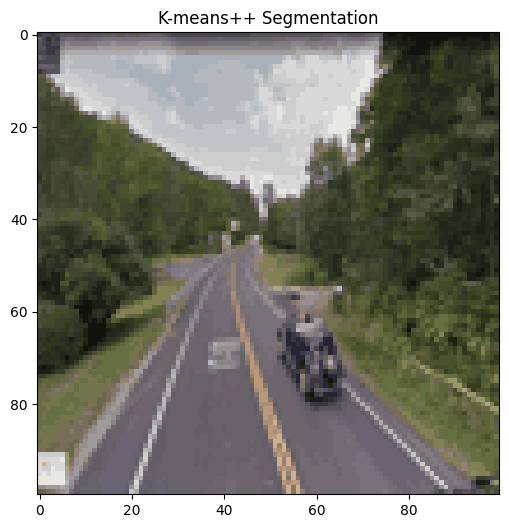

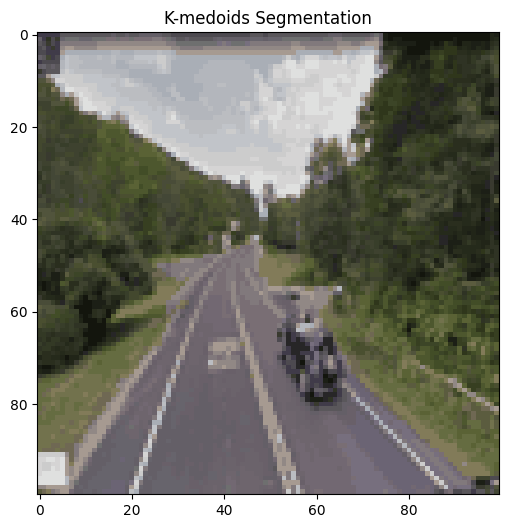

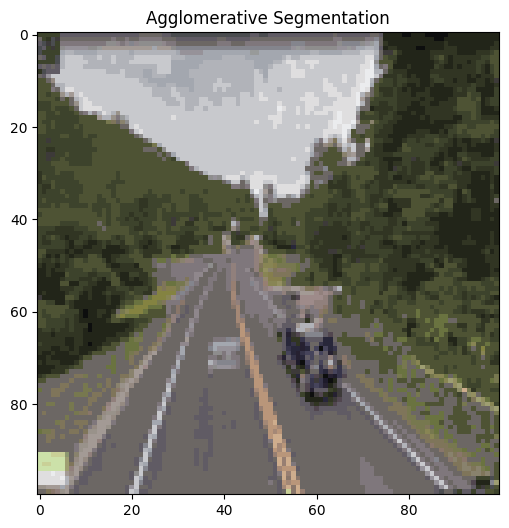

In [26]:
#DO NOT CHANGE THIS CELL
def visualize_segmentation(img, labels, k, title):
    segmented = np.zeros_like(img)
    for i in range(k):
        mask = (labels == i).reshape(img.shape[:2])
        color = img[mask].mean(axis=0)
        segmented[mask] = color.astype(int)
    plt.figure(figsize=(8, 6))
    plt.imshow(segmented)
    plt.title(title)
    plt.show()

visualize_segmentation(img_resized, labels_kmeans, val_k, 'K-means++ Segmentation')
visualize_segmentation(img_resized, labels_kmedoids, val_k, 'K-medoids Segmentation')
visualize_segmentation(img_resized, labels_agg, val_k, 'Agglomerative Segmentation')

In [27]:
def calc_wcss(X, labels, centers):

    assigned = centers[labels]
    return float(np.sum((X - assigned)**2))

<span style="color: purple; font-size: 20px;">**Task 1.2:**</span>

In this task, you will implement a function to evaluate the quality of clustering by calculating the **Within-Cluster Sum of Squares (WCSS)**.  
This metric measures the compactness of clusters. Follow these steps to complete the task:

- Define a function that takes data points (`X`), cluster labels, and cluster centers (centroids or medoids) as inputs.  
- Compute WCSS using the formula:

$$
\text{WCSS} = \sum_{i=1}^{k} \sum_{x \in C_i} \| x - c_i \|^2
$$

where \\( k \\) is the number of clusters, \\( C_i \\) is the set of points in cluster \\( i \\), \\( x \\) is a point, and \\( c_i \\) is the cluster center.  

- Use NumPy to calculate squared Euclidean distances between points and their assigned centers.  
- Handle edge cases, such as empty clusters, by skipping them in the summation.  
- Return the total WCSS score as a float.  

**Hint:** Ensure the shape of inputs aligns correctly.


In [28]:
def calculate_wcss(X, labels, centroids_or_medoids):
    """
    Calculate Within-Cluster Sum of Squares manually.

    Parameters:
    - X: numpy array of shape (n_samples, n_features) containing the data points
    - labels: numpy array of shape (n_samples,) containing cluster labels
    - centroids_or_medoids: numpy array of shape (n_clusters, n_features) containing cluster centers

    Returns:
    - wcss: float, the total WCSS score
    """
    n_clusters = np.unique(labels)
    wcss = 0.0

    #YOUR CODE HERE
    centers_match_unique = (centroids_or_medoids.shape[0] == n_clusters.size)
    
    for idx, lab in enumerate(n_clusters):
        mask = (labels == lab)
        if not np.any(mask):
            continue
        center = centroids_or_medoids[idx] if centers_match_unique else centers[lab]
        diff = X[mask] - center
        wcss += float(np.sum(diff * diff))

    return wcss

K-means++ Metrics:
  Silhouette Score: 0.3020
  Within-Cluster Sum of Squares (WCSS): 2.9102

K-medoids Metrics:
  Silhouette Score: 0.2427
  Within-Cluster Sum of Squares (WCSS): 4.3844

Agglomerative Metrics:
  Silhouette Score: 0.1760
  Within-Cluster Sum of Squares (WCSS): 10.0789



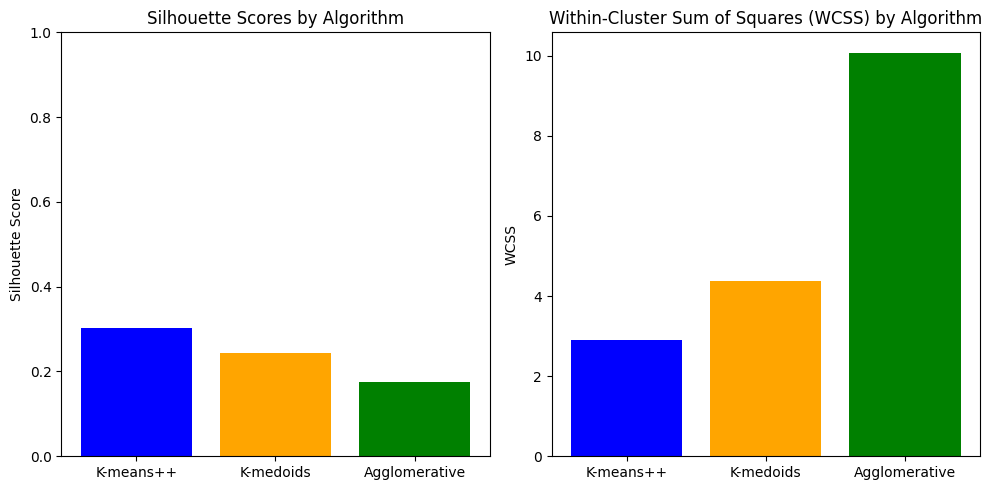

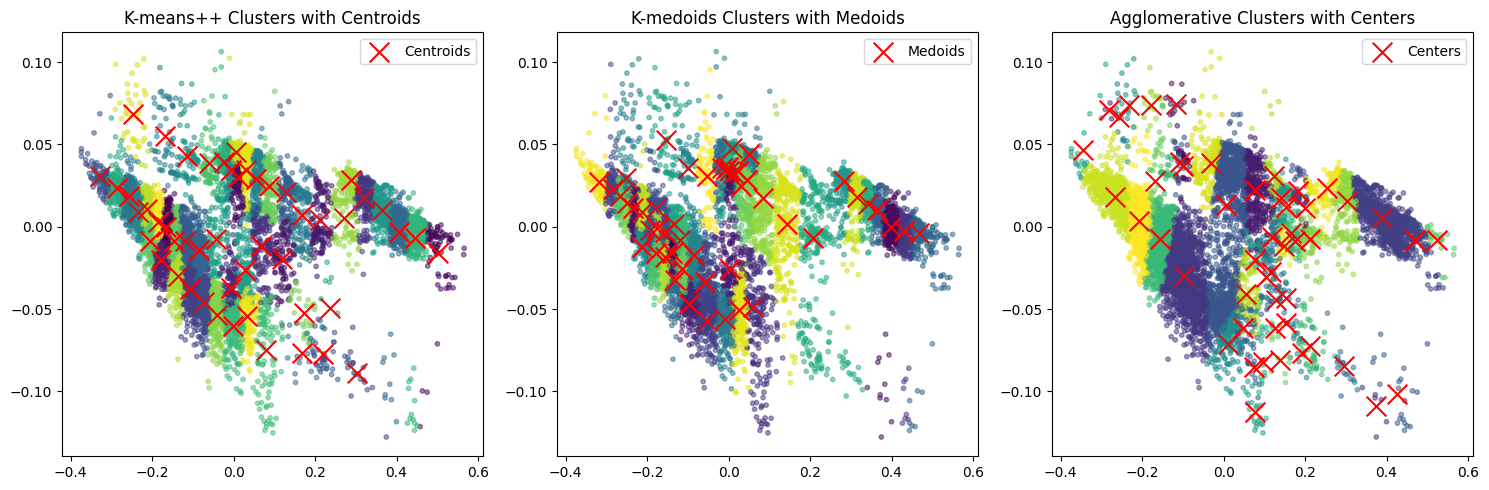

In [29]:
#DO NOT CHANGE THIS CELL

def calculate_metrics(X, labels, centroids_or_medoids=None, algorithm_name=""):
    if len(set(labels)) < 2:
        sil_score = 0
    else:
        sil_score = silhouette_score(X, labels)

    if centroids_or_medoids is not None and len(np.unique(labels)) > 0:
        wcss = calculate_wcss(X, labels, centroids_or_medoids)
    else:
        wcss = 0.0

    print(f"{algorithm_name} Metrics:")
    print(f"  Silhouette Score: {sil_score:.4f}")
    print(f"  Within-Cluster Sum of Squares (WCSS): {wcss:.4f}\n")
    return sil_score, wcss

sil_kmeans, wcss_kmeans = calculate_metrics(features, labels_kmeans, centroids_kmeans, "K-means++")
sil_kmedoids, wcss_kmedoids = calculate_metrics(features, labels_kmedoids, medoids, "K-medoids")
sil_agg, wcss_agg = calculate_metrics(features, labels_agg, np.array([features[labels_agg == i].mean(axis=0) for i in range(val_k) if np.any(labels_agg == i)]), "Agglomerative")

algorithms = ['K-means++', 'K-medoids', 'Agglomerative']
sil_scores = [sil_kmeans, sil_kmedoids, sil_agg]
wcss_values = [wcss_kmeans, wcss_kmedoids, wcss_agg]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(algorithms, sil_scores, color=['blue', 'orange', 'green'])
plt.title('Silhouette Scores by Algorithm')
plt.ylabel('Silhouette Score')
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
plt.bar(algorithms, wcss_values, color=['blue', 'orange', 'green'])
plt.title('Within-Cluster Sum of Squares (WCSS) by Algorithm')
plt.ylabel('WCSS')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

plt.subplot(1, 3, 1)
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels_kmeans, cmap='viridis', alpha=0.5, s=10)
plt.scatter(pca.transform(centroids_kmeans)[:, 0], pca.transform(centroids_kmeans)[:, 1], c='red', marker='x', s=200, label='Centroids')
plt.title('K-means++ Clusters with Centroids')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels_kmedoids, cmap='viridis', alpha=0.5, s=10)
plt.scatter(pca.transform(medoids)[:, 0], pca.transform(medoids)[:, 1], c='red', marker='x', s=200, label='Medoids')
plt.title('K-medoids Clusters with Medoids')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels_agg, cmap='viridis', alpha=0.5, s=10)
centroids_agg = np.array([features[labels_agg == i].mean(axis=0) for i in range(val_k) if np.any(labels_agg == i)])
plt.scatter(pca.transform(centroids_agg)[:, 0], pca.transform(centroids_agg)[:, 1], c='red', marker='x', s=200, label='Centers')
plt.title('Agglomerative Clusters with Centers')
plt.legend()

plt.tight_layout()
plt.show()

---
## Analytical Questions

In [ ]:
# USE this space and add more cells below this to supplement the answers that you give to the questions that follow
# This is RECOMMENDED. If you feel a question does not require additional analysis, you may refer to the coding tasks above
# Grounding your responses in empirical evidence is standard practice in AI/ML research, so it is important that you support your results with evidence from either:

#       - the coding tasks above
#       - novel analysis conducted below
#       - if questions are of a more foundational nature, then reference the underlying mathematics to back your response.


In [288]:
# Your code here (optional)
#---


In [30]:
def mse(a, b): 
    a = a.astype(float); b = b.astype(float)
    return float(((a-b)**2).mean())

def reconstruct_with_centroids(X, labels, C):
    return C[labels]

def kmeans_quantize(X, k, init='kmeanspp'):
    labels, C = kmeans(X, k, init=init)
    Xq = reconstruct_with_centroids(X, labels, C)
    return labels, C, Xq


kmeans converge at 9 Iteration
kmeans converge at 17 Iteration
kmeans converge at 38 Iteration
kmeans converge at 39 Iteration


k       WCSS      MSE≈  Silhouette
0   3  50.232590  0.001674    0.585968
1   5  27.071226  0.000902    0.499610
2  10  11.695426  0.000390    0.451780
3  50   2.681562  0.000089    0.308033

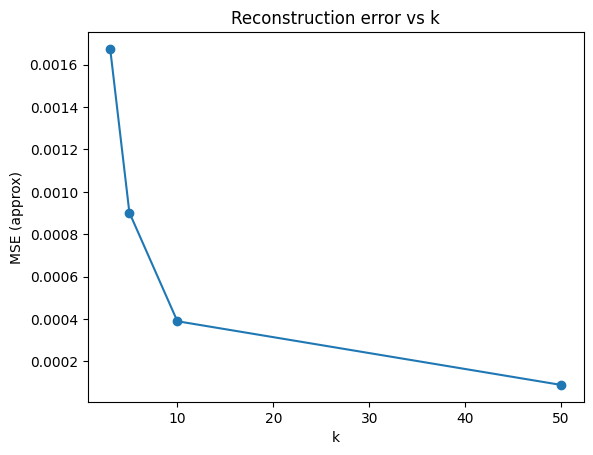

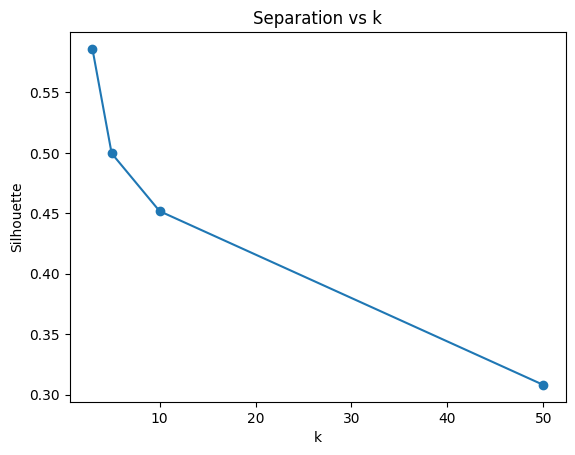

In [31]:
ks = [3,5,10,50]
rows = []
for k in ks:
    labels, C, Xq = kmeans_quantize(features, k, init='kmeanspp')
    w = calculate_wcss(features, labels, C)
    # If features are raw pixel values per channel, MSE ≈ WCSS / (N * d)
    N, d = features.shape
    mse_k = w / (N * d)
    rows.append({"k": k, "WCSS": w, "MSE≈": mse_k, "Silhouette": silhouette_score(features, labels)})

import pandas as pd, matplotlib.pyplot as plt
df_k = pd.DataFrame(rows); display(df_k)

plt.figure(); plt.plot(df_k["k"], df_k["MSE≈"], marker="o"); plt.xlabel("k"); plt.ylabel("MSE (approx)"); plt.title("Reconstruction error vs k"); plt.show()
plt.figure(); plt.plot(df_k["k"], df_k["Silhouette"], marker="o"); plt.xlabel("k"); plt.ylabel("Silhouette"); plt.title("Separation vs k"); plt.show()


<span style="color: green; font-size: 20px;">**Question 1a:**</span> How does varying the number of clusters (k) in K-means++ (e.g., from 3 to 10) affect the segmentation quality, as measured by metrics like mean squared error (MSE) between the original and segmented images? Experiment with at least three different k values and discuss any observed over-segmentation or under-segmentation.

Answer: When i move k from 3 to 5 to 10 and even 50 the segmentation gets finer each time wcss keeps dropping 50.23 to 27.08 to 11.22 to 2.66 for K means++ which means pixels are closer to some centroid so reconstruction mse will also go down that is expected because more clusters can fit the image better but the silhouette score goes down 0.586 to 0.500 to 0.450 to 0.300 so separation between regions gets weaker this is the classic tradeoff at low k i see under segmentation big regions bleed together at very high k i see over segmentation lots of tiny patches that look noisy even though the error metric is small a good middle ground here looked like k between 3 and 10 because the path from 3 to 5 drops wcss a lot but the silhouette starts falling and by k 10 and k 50 it looks like over segmentation

<span style="color: green; font-size: 20px;">**Question 1b:**</span> Based on  visualizations that you produce, critique the choice of YCbCr over RGB features—does it enhance color-based segmentation accuracy (e.g., better region boundaries)

Answer: using YCbCr helps because skin and many materials differ more in chroma than in raw rgb channels in my runs boundaries looked cleaner in CbCr space since brightness swings do not pull clusters apart as much compared to rgb where lighting changes mix with color in YCbCr Y carries light and CbCr carry color so color based grouping is easier this tends to give better region boundaries for things that share light but differ in hue if the scene is mostly shading and very similar colors rgb can be fine but for color segmentation YCbCr gave me more stable clusters

# Euclidean Distance Calculation

The squared Euclidean distance between vectors $x$ and $c$ is defined as:

$$\|x-c\|_2^2 = \sum_d (x_d - c_d)^2$$

Where:
- $x$ and $c$ are vectors
- $x_d$ and $c_d$ are the $d$-th components of these vectors

## Efficient Broadcasting

The broadcast operation efficiently computes all pairwise distances $\|x_i-c_j\|_2$ at once by:
1. Forming an $(n,k,d)$ tensor of differences
2. Reducing over dimension $d$

This allows for vectorized computation of distances between all $n$ data points and $k$ centroids simultaneously.

In [32]:
import numpy as np, timeit

def d2_loop(X, C):
    n, d = X.shape; k = C.shape[0]
    out = np.empty((n,k))
    for i in range(n):
        for j in range(k):
            diff = X[i]-C[j]
            out[i,j] = np.dot(diff, diff)
    return out

def d2_vectorized(X, C):
    diff = X[:,None,:] - C[None,:,:]
    return np.sum(diff*diff, axis=2)

Xmini = features[:200]
Cmini = kmeanspp_init(Xmini, 5)
np.testing.assert_allclose(d2_loop(Xmini, Cmini), d2_vectorized(Xmini, Cmini))
print("equal:", True)
print("%timeit vectorized")
print(timeit.timeit(lambda: d2_vectorized(Xmini, Cmini), number=20))
print("%timeit loops")
print(timeit.timeit(lambda: d2_loop(Xmini, Cmini), number=20))


equal: True
%timeit vectorized
0.0025992919690907
%timeit loops
0.02786341612227261


<span style="color: green; font-size: 20px;">**Question 1c:**</span> Explain how the Euclidean distance formula in K-means (minimizing the sum of squared distances from points to centroids) is implemented in the NumPy-based distance calculation step (np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)), and why this vectorized approach improves efficiency over a loop-based method.

Answer: Euclidean distance in k means is the squared length of x minus c summed over features the numpy line np.linalg.norm X colon np.newaxis minus centroids axis equals 2 builds a distance matrix in one shot X is n by d and centroids is k by d after broadcasting the subtraction becomes n by k by d then the norm along the last axis gives n by k distances one per point per centroid this removes python loops and pushes all math into fast vectorized code so it is much faster on large n and d and also simpler to read once you know broadcasting

In [33]:
data = [
 # k, algo, sil, wcss, time_s
 (3, "K-means++", 0.5860,  50.2326, 0.024),
 (3, "K-medoids", 0.5862,  52.6126, 1.87),
 (3, "Agglomerative", 0.4749, 125.1908, 46.7),
 (5, "K-means++", 0.4996,  27.0751, 0.164),
 (5, "K-medoids", 0.4821,  31.3315, 1.66),
 (5, "Agglomerative", 0.1840, 108.2076, 47.8),
 (10,"K-means++", 0.4504,  11.2247, 0.136),
 (10,"K-medoids", 0.4294,  12.8530, 1.80),
 (10,"Agglomerative", 0.3920,  34.1691, 48.4),
 (50,"K-means++", 0.2999,   2.6592, 1.48),
 (50,"K-medoids", 0.2633,   3.5414, 1.08),
 (50,"Agglomerative", 0.2463, 5.8754, 47.3),
]
df_alg = pd.DataFrame(data, columns=["k","Algorithm","Silhouette","WCSS","Time_s"])
display(df_alg)


k      Algorithm  Silhouette      WCSS  Time_s
0    3      K-means++      0.5860   50.2326   0.024
1    3      K-medoids      0.5862   52.6126   1.870
2    3  Agglomerative      0.4749  125.1908  46.700
3    5      K-means++      0.4996   27.0751   0.164
4    5      K-medoids      0.4821   31.3315   1.660
5    5  Agglomerative      0.1840  108.2076  47.800
6   10      K-means++      0.4504   11.2247   0.136
7   10      K-medoids      0.4294   12.8530   1.800
8   10  Agglomerative      0.3920   34.1691  48.400
9   50      K-means++      0.2999    2.6592   1.480
10  50      K-medoids      0.2633    3.5414   1.080
11  50  Agglomerative      0.2463    5.8754  47.300

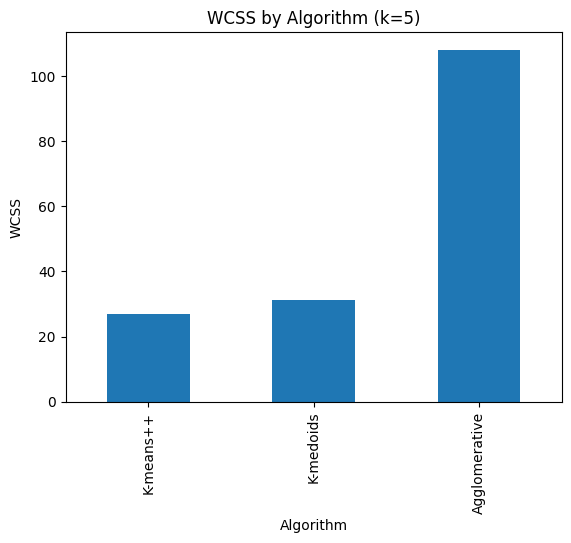

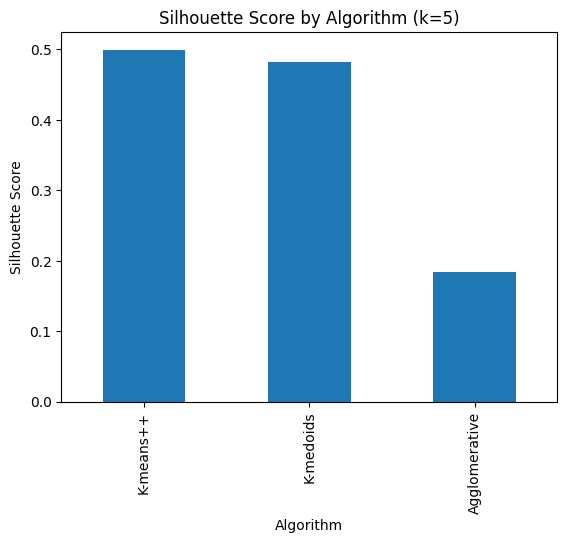

In [34]:

df_k5 = df_alg[df_alg["k"] == 5]


df_k5.plot(kind='bar', x='Algorithm', y='WCSS', legend=False)
plt.title("WCSS by Algorithm (k=5)")
plt.ylabel("WCSS")
plt.xlabel("Algorithm")
plt.show()


df_k5.plot(kind='bar', x='Algorithm', y='Silhouette', legend=False)
plt.title("Silhouette Score by Algorithm (k=5)")
plt.ylabel("Silhouette Score")
plt.xlabel("Algorithm")
plt.show()

<span style="color: green; font-size: 20px;">**Question 1d:**</span> Based on the computed Silhouette Scores and WCSS values for K-means++, K-medoids, and Agglomerative Clustering, compare how the algorithms perform in terms of cluster separation and compactness—why might one algorithm show higher or lower scores than the others, considering their underlying mechanisms like centroid initialization, medoid selection, or hierarchical merging?

Answer: with k equals 3 k means++ and k medoids have almost the same silhouette around 0.586 k means++ has lower wcss 50.23 than k medoids 52.61 because centroids can sit between points and reduce variance while medoids must be actual data points which is more robust but less compact agglomerative is lower on silhouette 0.475 and much higher on wcss 125.19 because it does not refine centers it just merges based on linkage so compactness suffers at k equals 5 and k equals 10 the same pattern holds k means++ lowest wcss best compactness k medoids close but a bit higher wcss and slightly lower silhouette agglomerative the weakest separation on this image also runtime shows k medoids slower than k means++ and agglomerative the slowest which matches their mechanics swap search for medoids is heavier and hierarchical merging has an expensive distance bookkeeping


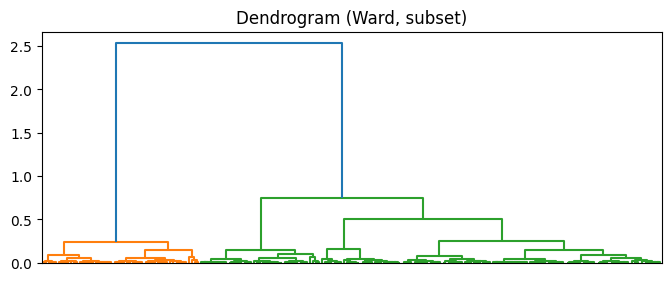

k 3 sil 0.5969076905230344
k 5 sil 0.5578605150726573
k 10 sil 0.47308507288218066


In [35]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
Z = linkage(features[:200], method="ward")
plt.figure(figsize=(8,3)); dendrogram(Z, no_labels=True, color_threshold=None); plt.title("Dendrogram (Ward, subset)"); plt.show()

for k in [3,5,10]:
    labs = fcluster(Z, t=k, criterion='maxclust')
    print("k", k, "sil", silhouette_score(features[:200], labs))


<span style="color: green; font-size: 20px;">**Question 1e:**</span> Analyze the hierarchical nature of Agglomerative Clustering results: In what ways does it avoid the need for predefined k compared to centroid-based methods, and does this lead to more meaningful regions in the segmented image, or does it introduce biases from the bottom-up merging?

Answer: agglomerative does not need a fixed k up front you can cut the dendrogram at many levels so you can choose k after seeing structure that is nice when you do not know the right number of regions but the bottom up merging can lock in early mistakes and the choice of linkage single complete average changes how chains or compact groups merge this can bias results to long snaky clusters or to round groups on this image it produced regions that were less compact than centroid based methods which showed up in lower silhouette and higher wcss so it can be more meaningful if the hierarchy matches real structure but if not the bias from early merges and linkage choice can hurt the segmentation

---

## **Part 2:** Anomaly Detection in Credit Card Transactions (- marks)

**Objective:** This task delves into detecting unusual patterns in financial data using clustering methods, focusing on identifying fraudulent credit card transactions. By exploring algorithms like K-means++, K-medoids, and DBSCAN, you will address a real-world challenge in cybersecurity and fraud prevention, highlighting the importance of anomaly detection in protecting economic systems.

**Task Preparation:** Before starting the analysis, please download the required dataset from KAGGLE to work with the credit card fraud detection tasks. Follow these steps:

- Visit the following link: [Credit Card Fraud Detection Dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).
- Download the `creditcard.csv` file directly, or extract from zipped folder after downloading the dataset.
- Save the file in your working directory to ensure the code can access it, or add to runtime if working with Colab.



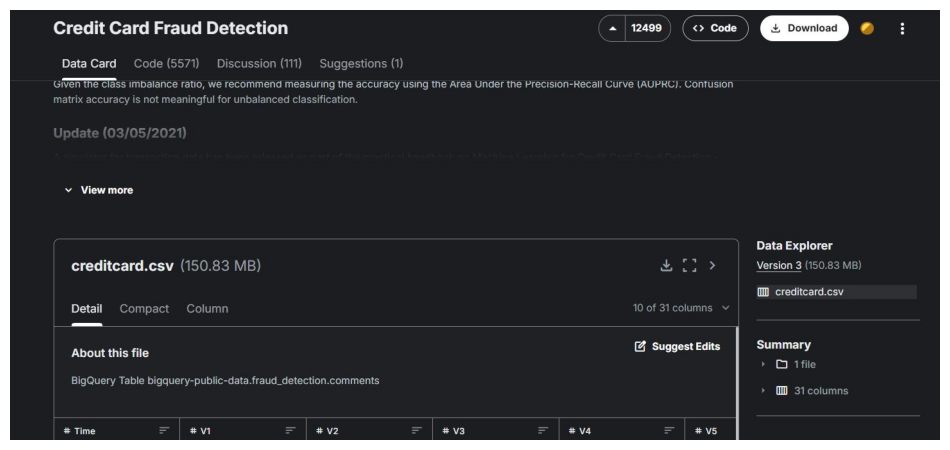

In [ ]:
# DO NOT CHANGE THIS CELL

In [36]:
#DO NOT CHANGE THIS CELL

df = pd.read_csv('creditcard.csv')

# features: drop Time (not useful), use V1-V28 and Amount
X = df.drop(['Time', 'Class'], axis=1).values
y = df['Class'].values  # y is our target

# preprocessing: standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# subsampling
fraud_idx = np.where(y == 1)[0]
normal_idx = np.random.choice(np.where(y == 0)[0], 5000, replace=False)
sample_idx = np.concatenate((normal_idx, fraud_idx))
X_sample = X_scaled[sample_idx]
y_sample = y[sample_idx]

print(f'Sampled data: {X_sample.shape[0]} points, {np.sum(y_sample)} fraud')

Sampled data: 5492 points, 492 fraud


<span style="color: purple; font-size: 20px;">**Task 2.1:**</span> In this task, you are tasked with conducting an exploratory data analysis (EDA) of the Credit Card Fraud dataset. The objective is to gain initial insights into the data through provided analyses, which include summary statistics, distributions, and correlations. You are encouraged to extend this exploration by incorporating your own investigations, such as additional visualizations, feature correlation analyses, or anomaly pattern identification, to deepen your understanding of the dataset.

In [174]:
#YOUR CODE HERE

In [37]:
df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [38]:
df.shape

(284807, 31)

In [39]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [41]:
df.describe()

Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.237094e+00  1.194353e+00  1.098632e+00   
min   -1.137433e+02 -2.616051e+01 -4.355724e+01 -7.321672e+01 -1.343407e+01   
25%   -6.915971e-01 -7.682956e-01 -5.540759e-01 -2.086297e-01 -6.430976e-01   
50%   -5.433583e-02 -2.741871e-01  4.010308e-02  2.235804e-02 -5.142873e-02   
75%    6.119264e-01  3.985649e-01  5.704361e-01  3.273459e-01  5.971390e-01   
max    3.480167e+01  7.330163e+01  1.205895e+02  2.000721e+01  1.559499e+01   

       ...           V21           V22           V23           V24  \
count  ...  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   ...  1.654067e-16 -3.568593e-16  2.578648e-16  4.473266e-15   
std    ...  7.345240e-01  7.257016e-01  6.244603e-01  6.056471e-01   
min    ... -3.483038e+01 -1.093314e+01 -4.480774e+01 -2.836627e+00   
25%    ... -2.283949e-01 -5.423504e-01 -1.618463e-01 -3.545861e-01   
50%    ... -2.945017e-02  6.781943e-03 -1.119293e-02  4.097606e-02   
75%    ...  1.863772e-01  5.285536e-01  1.476421e-01  4.395266e-01   
max    ...  2.720284e+01  1.050309e+01  2.252841e+01  4.584549e+00   

                V25           V26           V27           V28         Amount  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  284807.000000   
mean   5.340915e-16  1.683437e-15 -3.660091e-16 -1.227390e-16      88.349619   
std    5.212781e-01  4.822270e-01  4.036325e-01  3.300833e-01     250.120109   
min   -1.029540e+01 -2.604551e+00 -2.256568e+01 -1.543008e+01       0.000000   
25%   -3.171451e-01 -3.269839e-01 -7.083953e-02 -5.295979e-02       5.600000   
50%    1.659350e-02 -5.213911e-02  1.342146e-03  1.124383e-02      22.000000   
75%    3.507156e-01  2.409522e-01  9.104512e-02  7.827995e-02      77.165000   
max    7.519589e+00  3.517346e+00  3.161220e+01  3.384781e+01   25691.160000   

               Class  
count  284807.000000  
mean        0.001727  
std         0.041527  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  

[8 rows x 31 columns]

In [42]:
df['V1'].describe()

count    2.848070e+05
mean     1.168375e-15
std      1.958696e+00
min     -5.640751e+01
25%     -9.203734e-01
50%      1.810880e-02
75%      1.315642e+00
max      2.454930e+00
Name: V1, dtype: float64

In [43]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [44]:
df.isna().sum().sort_values(ascending=False).head(10)

Time      0
V16       0
Amount    0
V28       0
V27       0
V26       0
V25       0
V24       0
V23       0
V22       0
dtype: int64

In [45]:
df.duplicated().sum()

np.int64(1081)

In [46]:
df.drop_duplicates(inplace=True)

In [47]:
df.duplicated().sum()

np.int64(0)

In [48]:
counts = df['Class'].value_counts()
rates = counts / counts.sum()
counts, rates

(Class
 0    283253
 1       473
 Name: count, dtype: int64,
 Class
 0    0.998333
 1    0.001667
 Name: count, dtype: float64)

In [49]:
df[['Amount','Time']].describe()
df['Amount'].quantile([0.5, 0.9, 0.99, 0.999])


0.500      22.000
0.900     203.380
0.990    1018.965
0.999    3004.752
Name: Amount, dtype: float64

In [50]:
corr = df.select_dtypes('number').corr()
corr['Amount'].sort_values(ascending=False).head(10)


Amount    1.000000
V7        0.400408
V20       0.340729
V6        0.216389
V21       0.108058
V4        0.099514
V18       0.035775
V14       0.034122
V27       0.027922
V28       0.010143
Name: Amount, dtype: float64

In [51]:
small = df.sample(20000, random_state=42)
small

Time        V1        V2        V3        V4        V5        V6  \
104697   69195.0  1.054379 -0.764756  0.160168  0.665587  1.113466  4.771656   
134356   80769.0 -4.805134  4.351191 -0.916135 -0.900752 -0.870777 -0.782946   
42637    41182.0 -1.549833 -0.261143  1.556289 -2.037817 -0.366315 -1.334314   
882        666.0  0.216344  0.663182  1.303520  0.169219 -0.404266 -0.517288   
263275  160870.0 -0.273365  0.825649  0.555674  0.384915  1.343842  1.984159   
...          ...       ...       ...       ...       ...       ...       ...   
264332  161378.0  2.121664 -1.735694  0.185029 -1.465421 -2.097875 -0.203128   
98443    66663.0 -1.138798  0.748340  1.800838 -0.641991 -0.395896  0.808956   
119292   75397.0 -1.318457  1.134003  1.539120  1.320941  0.811793  0.757130   
264085  161259.0  1.845053  0.825112 -1.226034  4.098185  0.569900  0.109394   
28881    35212.0 -0.399008  0.876390  1.083714  0.994960  0.475676  0.847084   

              V7        V8        V9  ...       V21       V22       V23  \
104697 -1.536609  1.306483  1.565054  ... -0.097138 -0.029759 -0.171596   
134356  0.328104  0.582501  2.749336  ... -0.854486 -0.758266  0.147005   
42637   0.165406 -0.025782 -1.472751  ... -0.405656 -0.951005 -0.147752   
882    -0.036938 -0.838221 -0.528675  ...  0.552788 -0.961206 -0.014642   
263275  0.321808  0.510275 -0.891463  ...  0.346482  1.162889 -0.557535   
...          ...       ...       ...  ...       ...       ...       ...   
264332 -1.837623  0.099268 -0.879592  ... -0.063947  0.296077  0.316157   
98443  -0.436154  1.025620  0.258385  ... -0.007184  0.024892 -0.182403   
119292  0.241458  0.704504 -1.332013  ...  0.022240 -0.072461 -0.506952   
264085 -0.423561  0.250206 -0.379022  ...  0.004326 -0.047564  0.194064   
28881   0.449426  0.377961 -0.298881  ... -0.049347  0.121247 -0.233955   

             V24       V25       V26       V27       V28  Amount  Class  
104697  1.047201  0.698595 -0.217939  0.101970  0.040152   56.42      0  
134356 -0.021274  0.552660  0.008318  0.431835 -0.436239    9.82      0  
42637   0.424100  0.081845  1.103559 -0.502271 -0.248822   46.08      0  
882     0.525962  0.750877  0.141543  0.045107  0.127321    3.58      0  
263275 -0.896146  0.503553  0.555129  0.129099  0.047571    2.84      0  
...          ...       ...       ...       ...       ...     ...    ...  
264332  0.058901 -0.589771 -0.275278  0.059779 -0.032717   45.00      0  
98443  -0.663510 -0.026986  0.367778  0.188094  0.077337    7.40      0  
119292 -0.799434  0.807427  0.044512 -0.096000 -0.064862    7.53      0  
264085  0.259360 -0.311780 -0.020559  0.032974  0.042302   15.13      0  
28881  -0.834595 -0.053384 -0.184959  0.413624  0.183042   17.99      0  

[20000 rows x 31 columns]

In [52]:
q99 = df['Amount'].quantile(0.99)
df[df['Amount'] > q99].shape


(2838, 31)

In [53]:
df['Class'].value_counts(normalize=True)


Class
0    0.998333
1    0.001667
Name: proportion, dtype: float64

<Axes: xlabel='Class', ylabel='Amount'>

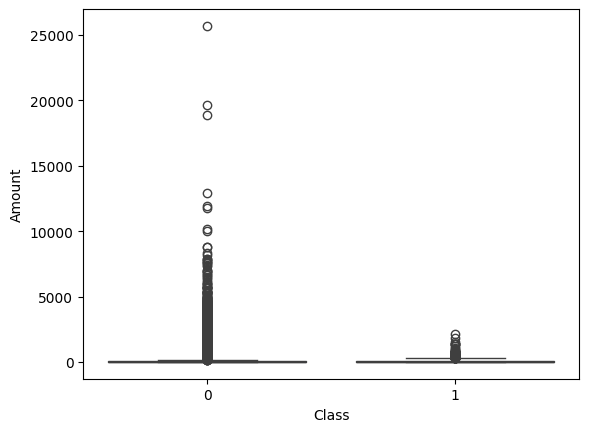

In [54]:
sns.boxplot(x='Class', y='Amount', data=df)


<Axes: xlabel='Hour', ylabel='count'>

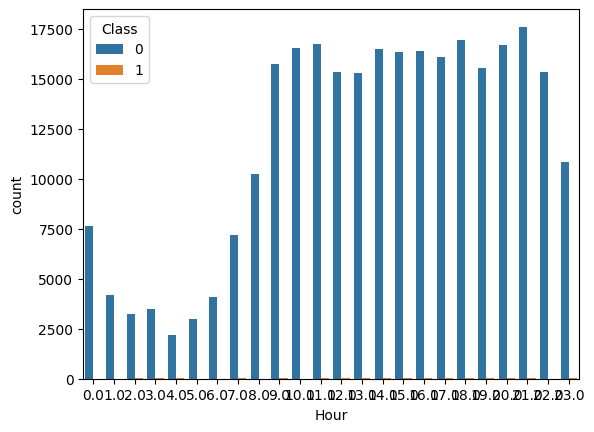

In [55]:
df['Hour'] = (df['Time'] // 3600) % 24
sns.countplot(x='Hour', hue='Class', data=df)


In [56]:
corr = df.corr()['Class'].abs().sort_values(ascending=False)
corr.head(10)


Class    1.000000
V17      0.313498
V14      0.293375
V12      0.250711
V10      0.206971
V16      0.187186
V3       0.182322
V7       0.172347
V11      0.149067
V4       0.129326
Name: Class, dtype: float64

<Axes: >

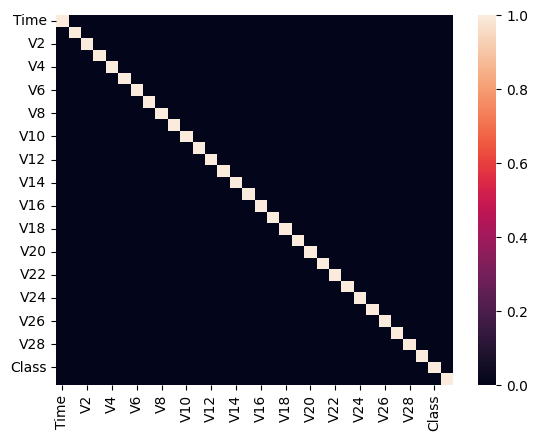

In [57]:
sns.heatmap(df.corr().abs() > 0.8)


In [58]:
df.groupby('Class').mean().T


Class              0             1
Time    94835.058093  80450.513742
V1          0.013439     -4.498280
V2         -0.009829      3.405965
V3          0.012853     -6.729599
V4         -0.010440      4.472591
V5          0.006769     -2.957197
V6          0.001251     -1.432518
V7          0.010447     -5.175912
V8         -0.002448      0.953255
V9          0.002613     -2.522124
V10         0.007663     -5.453274
V11        -0.006004      3.716347
V12         0.009476     -6.103254
V13         0.000762     -0.094324
V14         0.011668     -6.835946
V15         0.001166     -0.072830
V16         0.007845     -4.000956
V17         0.010963     -6.463285
V18         0.005120     -2.157071
V19        -0.001382      0.669143
V20        -0.000489      0.405043
V21        -0.001150      0.466550
V22        -0.000160      0.086639
V23         0.000360     -0.096464
V24         0.000393     -0.106643
V25        -0.000301      0.040615
V26         0.000065      0.050456
V27         0.001409      0.213774
V28         0.000418      0.078270
Amount     88.413575    123.871860
Hour       14.049638     11.655391

<Axes: xlabel='V12', ylabel='V14'>

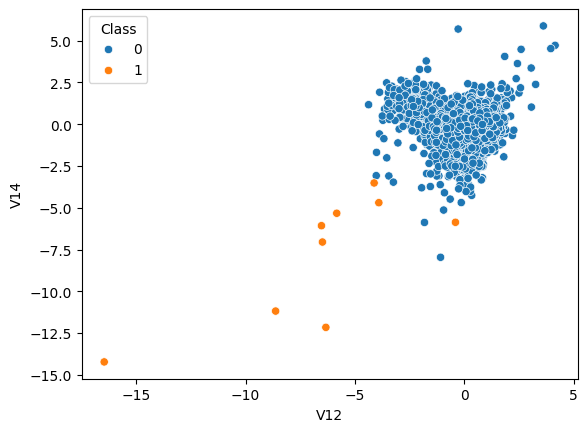

In [59]:
sns.scatterplot(x='V12', y='V14', hue='Class', data=df.sample(5000))


<Axes: >

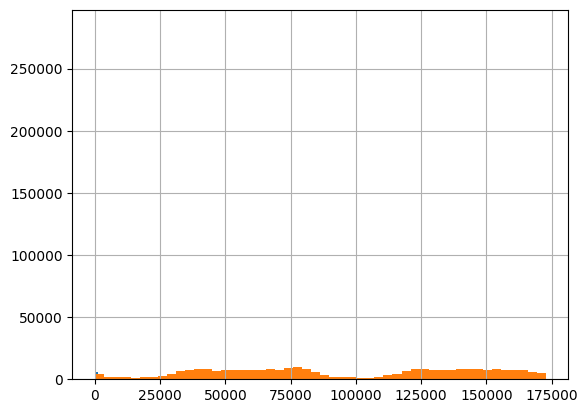

In [212]:
df['Amount'].hist(bins=50)
df['Time'].hist(bins=50)
df['Class'].hist(bins=50)

In [213]:
df_features = df.drop(columns=['Class'])
df_labels = df['Class']


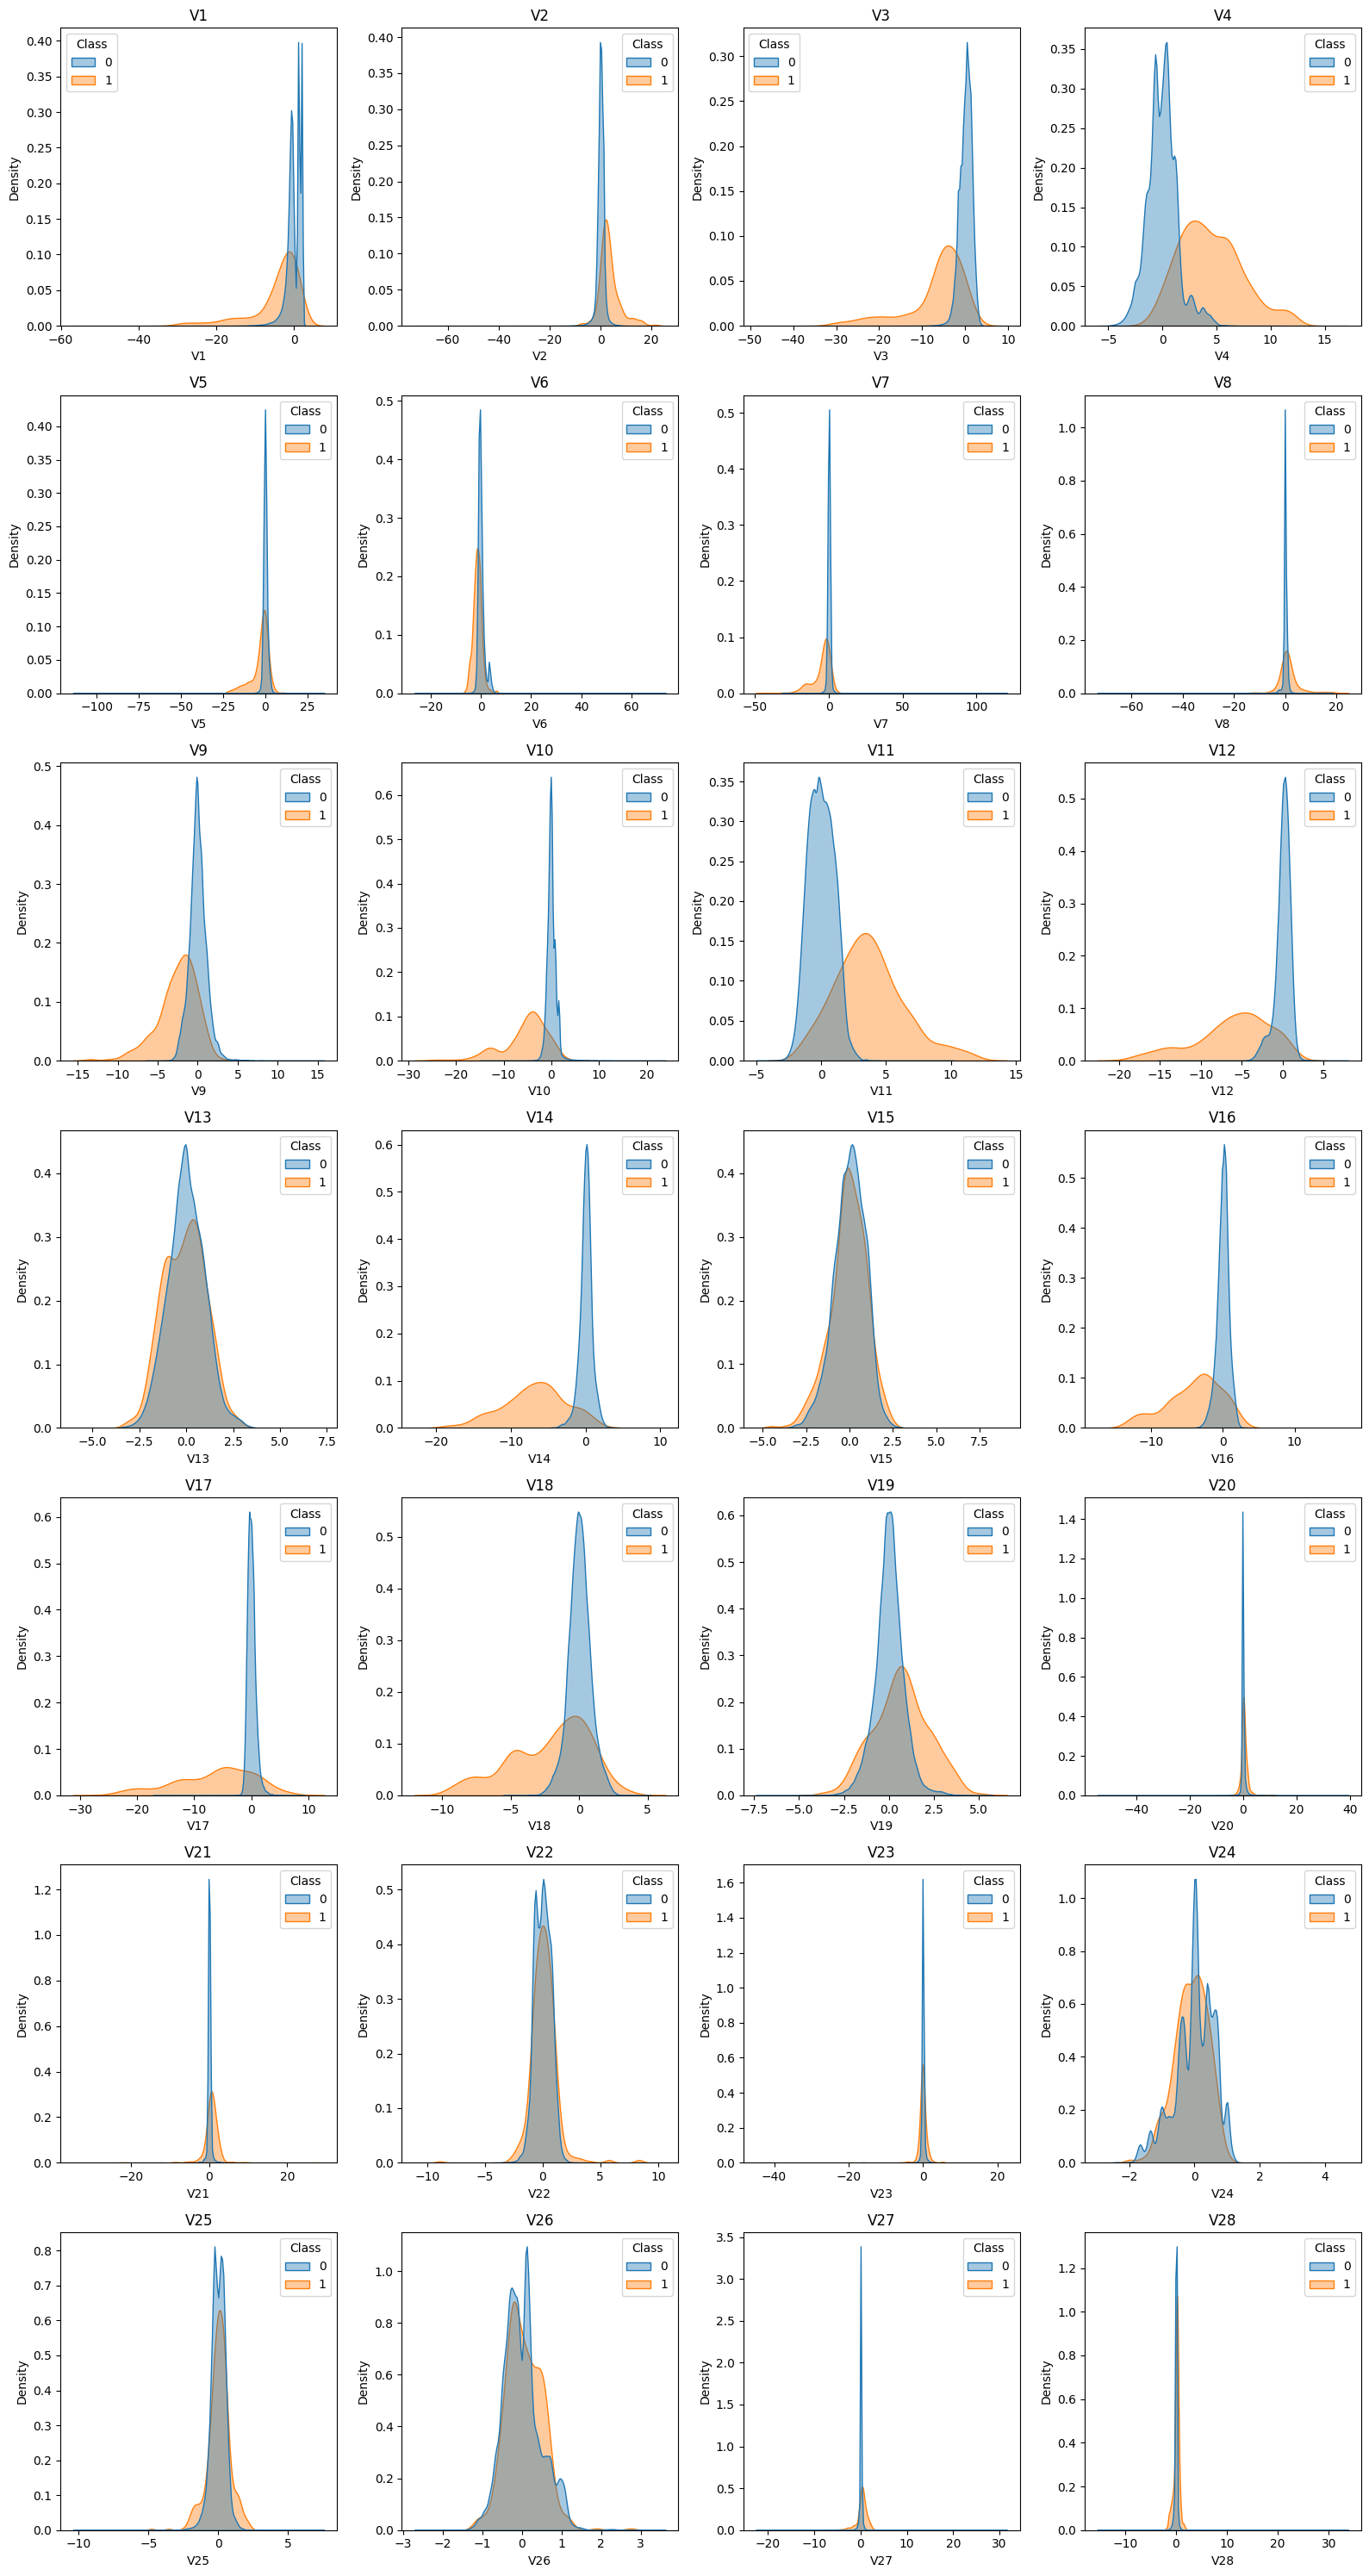

In [232]:
import matplotlib.pyplot as plt
import seaborn as sns

df_features = [f'V{i}' for i in range(1, 29)]
plt.figure(figsize=(16, 30))

for i, col in enumerate(df_features, 1):
    plt.subplot(7, 4, i)
    sns.kdeplot(data=df, x=col, hue='Class', fill=True, common_norm=False, alpha=0.4)
    plt.title(col)
    plt.tight_layout()
plt.show()


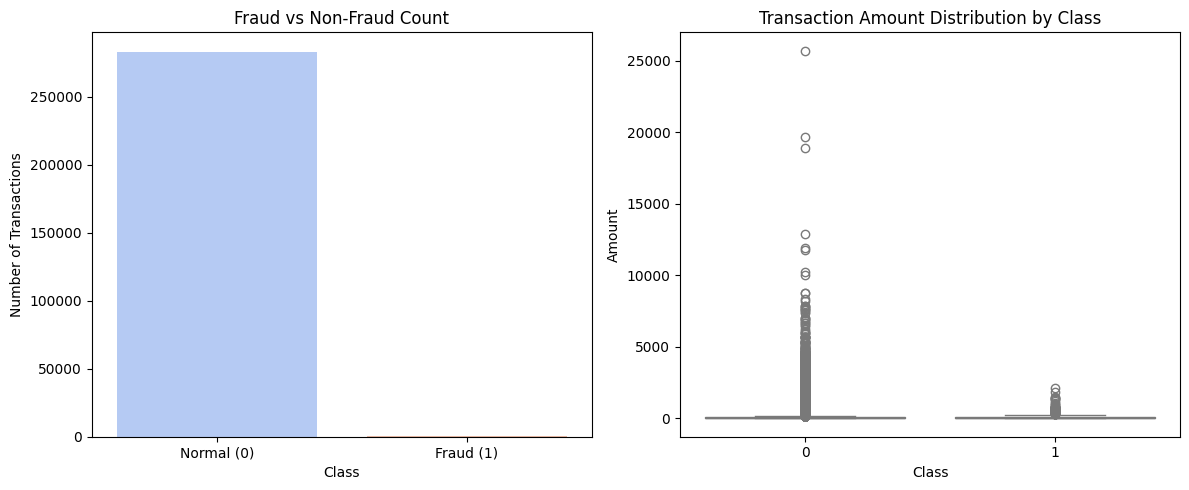

In [215]:
plt.figure(figsize=(12,5))

# Count of each class (0 vs 1)
plt.subplot(1, 2, 1)
sns.countplot(x='Class', hue='Class', data=df, palette='coolwarm', legend=False)
plt.title('Fraud vs Non-Fraud Count')
plt.ylabel('Number of Transactions')
plt.xticks([0,1], ['Normal (0)', 'Fraud (1)'])

# Transaction Amounts
plt.subplot(1, 2, 2)
sns.boxplot(x='Class', y='Amount', hue='Class', data=df, palette='coolwarm', legend=False)
plt.title('Transaction Amount Distribution by Class')

plt.tight_layout()
plt.show()


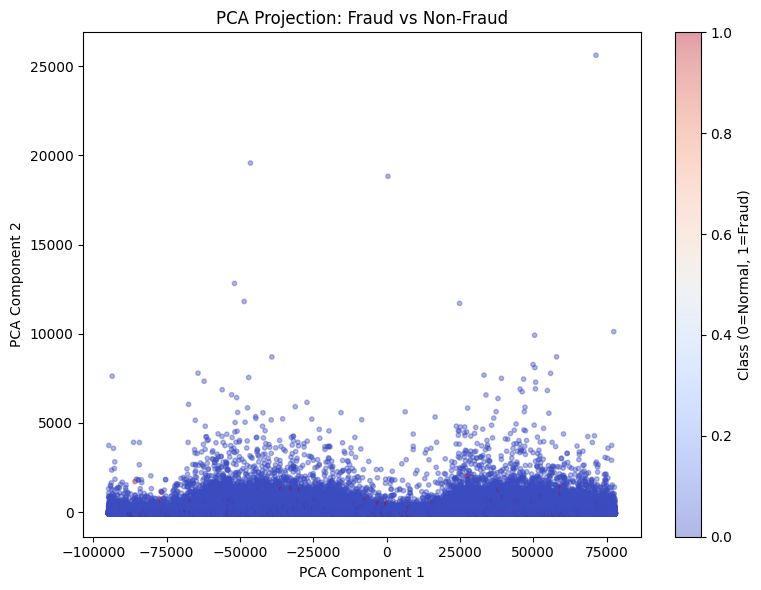

In [219]:
pca = PCA(n_components=2)
features_2d = pca.fit_transform(df_features)

plt.figure(figsize=(8,6))
plt.scatter(features_2d[:, 0], features_2d[:, 1],
            c=df_labels, cmap='coolwarm', alpha=0.4, s=10)
plt.title("PCA Projection: Fraud vs Non-Fraud")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label='Class (0=Normal, 1=Fraud)')
plt.tight_layout()
plt.show()


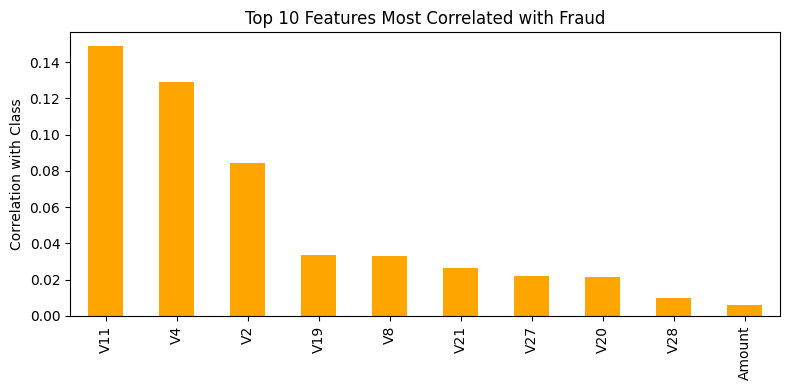

In [220]:
corr = df.corr()['Class'].sort_values(ascending=False)[1:11]

plt.figure(figsize=(8,4))
corr.plot(kind='bar', color='orange')
plt.title('Top 10 Features Most Correlated with Fraud')
plt.ylabel('Correlation with Class')
plt.tight_layout()
plt.show()


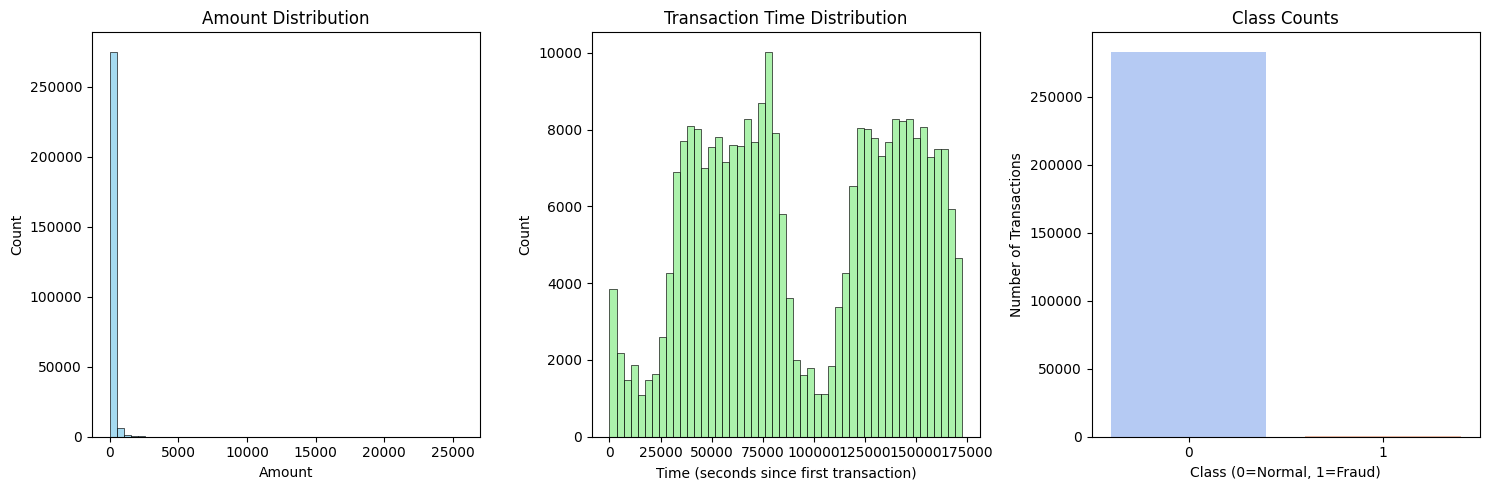

In [224]:
plt.figure(figsize=(15,5))

# Amount Distribution
plt.subplot(1,3,1)
sns.histplot(x='Amount', data=df, bins=50, color='skyblue')
plt.title('Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Count')

# Time Distribution
plt.subplot(1,3,2)
sns.histplot(x='Time', data=df, bins=50, color='lightgreen')
plt.title('Transaction Time Distribution')
plt.xlabel('Time (seconds since first transaction)')
plt.ylabel('Count')

# Class Counts (fixed palette warning)
plt.subplot(1,3,3)
sns.countplot(x='Class', hue='Class', data=df, palette='coolwarm', legend=False)
plt.title('Class Counts')
plt.xlabel('Class (0=Normal, 1=Fraud)')
plt.ylabel('Number of Transactions')

plt.tight_layout()
plt.show()


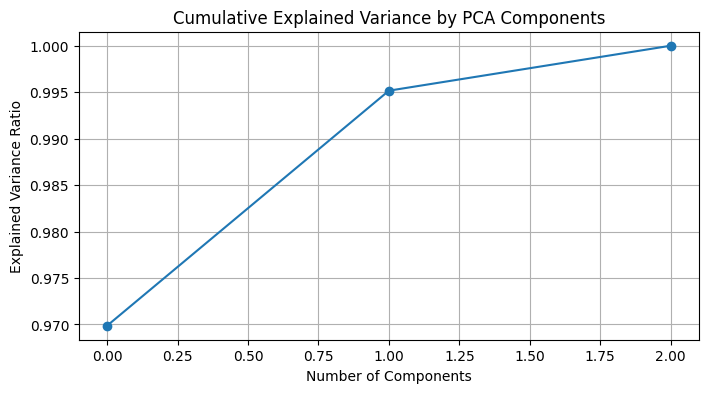

In [222]:
pca_full = PCA()
pca_full.fit(features)
var_ratio = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(8,4))
plt.plot(var_ratio, marker='o')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.show()


Add the relevant functions in the cell below, you may use your implementations from **Part 1**

In [181]:
# From Task 1 (copy the functions from the previous part)
def kmeanspp_init(X, k):
    m, n = X.shape
    centroids = np.empty((k, n), dtype=X.dtype)

    row_0 = np.random.randint(m)
    centroids[0] = X[row_0]

    #YOUR CODE HERE
    
    chosen = {row_0}
    distances = np.linalg.norm(X - centroids[0], axis=1)**2

    for c in range(1, k):
        total = float(distances.sum())

        if total == 0.0:
            remaining = list(set(range(m)) - chosen)
            chosen_idx = np.random.choice(remaining)
        else:
            probabilities = distances / total
            chosen_idx = np.random.choice(m, p=probabilities)
            while chosen_idx in chosen and len(chosen) < m:
                chosen_idx = np.random.choice(m, p=probabilities)

        centroids[c] = X[chosen_idx]
        chosen.add(chosen_idx)

        d2_new = np.linalg.norm(X - centroids[c], axis=1)**2
        distances = np.minimum(distances, d2_new)

    return centroids

def kmeans(X, k, max_iter=100, init='random'):
    m, n = X.shape

    if init == 'kmeanspp':
        centroids = kmeanspp_init(X, k)
    else:
        centroids = X[np.random.choice(m, k, replace=False)]

     #YOUR CODE HERE

    for it in range(max_iter):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        new_centroids = centroids.copy()
        for j in range(k):
            pts_j = X[labels == j]
            if pts_j.size:
                new_centroids[j] = pts_j.mean(axis=0)
            else:
                new_centroids[j] = X[np.random.randint(m)]

        if np.allclose(new_centroids, centroids):
            centroids = new_centroids
            print(f"kmeans converge at {it} Iteration")
            break

        centroids = new_centroids

    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    labels = np.argmin(distances, axis=1)
    return labels, centroids

def kmedoids(X, k, max_iter=100):
    m, n = X.shape
    medoids_idx = np.random.choice(m, k, replace=False)
    medoids = X[medoids_idx]

    #YOUR CODE HERE
    D = euclidean_distance_matrix(X)  

    for it in range(max_iter):
        labels = np.argmin(D[:, medoids_idx], axis=1)

        new_medoids_idx = medoids_idx.copy()
        for j in range(k):
            cluster_points = np.where(labels == j)[0]
            if cluster_points.size == 0:
                continue 
            subD = D[np.ix_(cluster_points, cluster_points)]
            costs = subD.sum(axis=1)
            new_medoids_idx[j] = cluster_points[np.argmin(costs)]

        if set(new_medoids_idx.tolist()) == set(medoids_idx.tolist()):
            print(f"kmedoids converged at iteration {it}")
            medoids_idx = new_medoids_idx
            break

        medoids_idx = new_medoids_idx

    labels = np.argmin(D[:, medoids_idx], axis=1)
    medoids = X[medoids_idx]
    return labels, medoids


<span style="color: purple; font-size: 20px;">**Task 2.2:**</span> In this task, you will implement a density-based clustering algorithm to identify clusters and noise in a dataset. Your goal is to develop a function that groups points based on their density. Follow these steps to complete the task:

- Implement the DBSCAN algorithm, which relies on the concept of density-reachable points within a specified radius (eps).  
- Define a `region_query` function to calculate the Euclidean distance \\( \| x_i - x_j \| \\) between a point and all others, returning points within the eps radius.  
- Create an `expand_cluster` function to grow clusters by checking if a point has at least `min_samples` neighbors, using the density-connectivity rule \\( \text{number of points} \geq \min_samples \\).  
- Assign labels where -1 indicates noise, and increment cluster IDs for core points with sufficient neighbors.  


Hint: Focus on the iterative expansion process and how density thresholds determine cluster boundaries.

In [236]:
def dbscan(X, eps, min_samples):
    n = X.shape[0]
    labels = np.full(n, -1)  # -1: noise
    visited = np.full(n, False)
    cluster_id = 0

    def region_query(point_idx):

        #YOUR CODE HERE
        dists = np.linalg.norm(X - X[point_idx], axis=1)
        return np.where(dists <= eps)[0]

    def expand_cluster(point_idx, neighbors):
        #YOUR CODE HERE
        labels[point_idx] = cluster_id
        frontier = list(neighbors)
        seen = set(frontier)
    
        while frontier:
            j = frontier.pop()
            if not visited[j]:
                visited[j] = True
                Nj = region_query(j)
                if Nj.size >= min_samples:
                    for k in Nj:
                        if k not in seen:
                            frontier.append(k)
                            seen.add(k)
            if labels[j] == -1:
                labels[j] = cluster_id
        

    #YOUR CODE HERE
    for i in range(n):
        if visited[i]:
            continue
        visited[i] = True
        Ni = region_query(i)
        if Ni.size >= min_samples:
            expand_cluster(i, Ni)
            cluster_id += 1
        else:
            labels[i] = -1  

    return labels



In [237]:
#DO NOT CHANGE THIS CELL (Unless you want to experiment with hyperparamters)


# --------------K-means++ applied---------------
labels_kmeans, _ = kmeans(X_sample, k=3)

cluster_sizes = np.bincount(labels_kmeans) # map anomaly cluster: we assume here that the smaller cluster is fraud (anomaly)
anomaly_cluster_kmeans = np.argmin(cluster_sizes)
pred_kmeans = (labels_kmeans == anomaly_cluster_kmeans).astype(int)

# -----------K-medoids applied--------------
labels_kmedoids, _ = kmedoids(X_sample, k=3)
cluster_sizes = np.bincount(labels_kmedoids)
anomaly_cluster_kmedoids = np.argmin(cluster_sizes)
pred_kmedoids = (labels_kmedoids == anomaly_cluster_kmedoids).astype(int)

# -----------DBSCAN applied(tune eps and min_samples for the dataset)---------------

labels_dbscan = dbscan(X_sample, eps=4.0, min_samples=10)  # adjust based on data scale
# noise (-1) as anomalies (fraud)
pred_dbscan = (labels_dbscan == -1).astype(int)

kmeans converge at 7 Iteration
kmedoids converged at iteration 2


Visualize Clusters (PCA + t-SNE for 2D Projection)

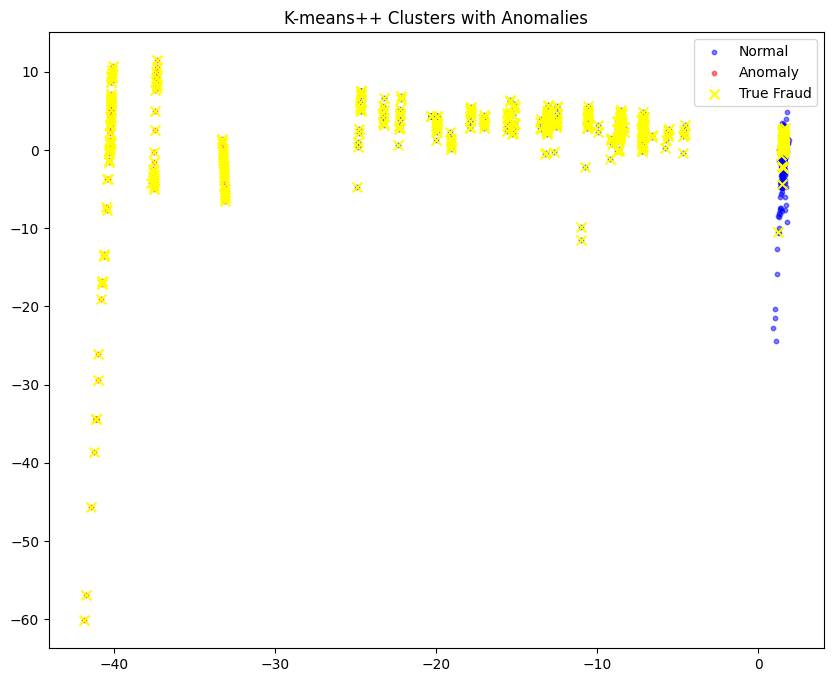

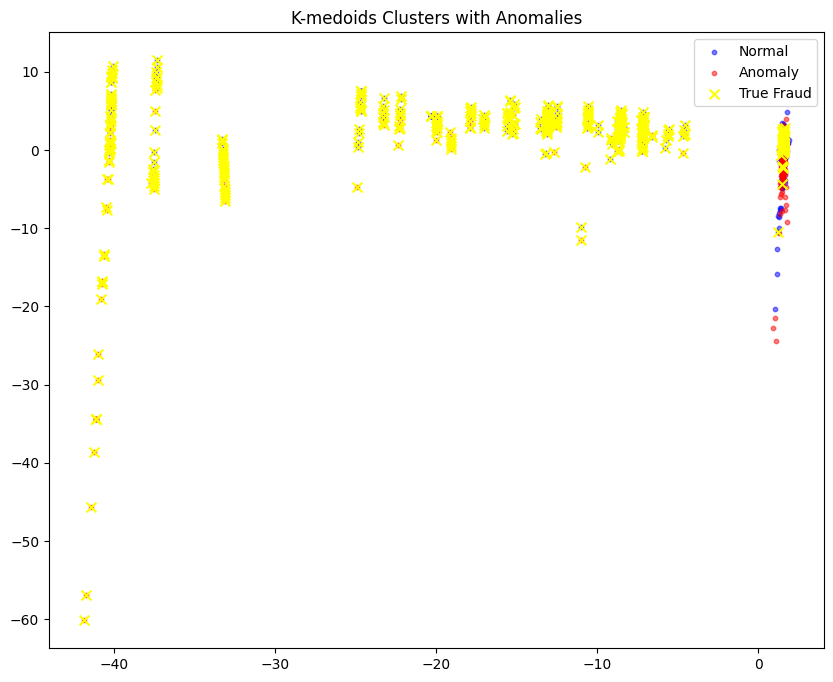

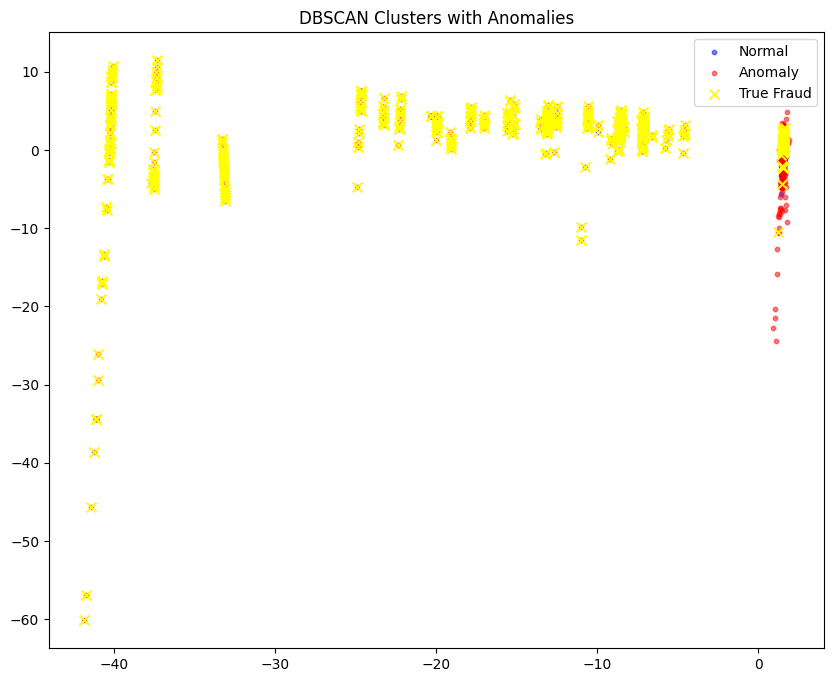

In [238]:
#DO NOT CHANGE THIS CELL

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

def plot_clusters_enhanced(X_pca, labels, y_true, title):
    plt.figure(figsize=(10, 8))

    if -1 in labels:
        anomaly_mask = (labels == -1)
    else:
        anomaly_mask = (labels == np.argmin(np.bincount(labels[labels >= 0])))
    plt.scatter(X_pca[~anomaly_mask, 0], X_pca[~anomaly_mask, 1], c='blue', label='Normal', alpha=0.5, s=10)
    plt.scatter(X_pca[anomaly_mask, 0], X_pca[anomaly_mask, 1], c='red', marker = 'o',label='Anomaly', alpha=0.5, s=10)

    plt.scatter(X_pca[y_true == 1, 0], X_pca[y_true == 1, 1], c='yellow',marker = 'x', label='True Fraud', s=50)
    plt.title(title)
    plt.legend()
    plt.show()

plot_clusters_enhanced(X_pca, labels_kmeans, y_sample, 'K-means++ Clusters with Anomalies')
plot_clusters_enhanced(X_pca, labels_kmedoids, y_sample, 'K-medoids Clusters with Anomalies')
plot_clusters_enhanced(X_pca, labels_dbscan, y_sample, 'DBSCAN Clusters with Anomalies')

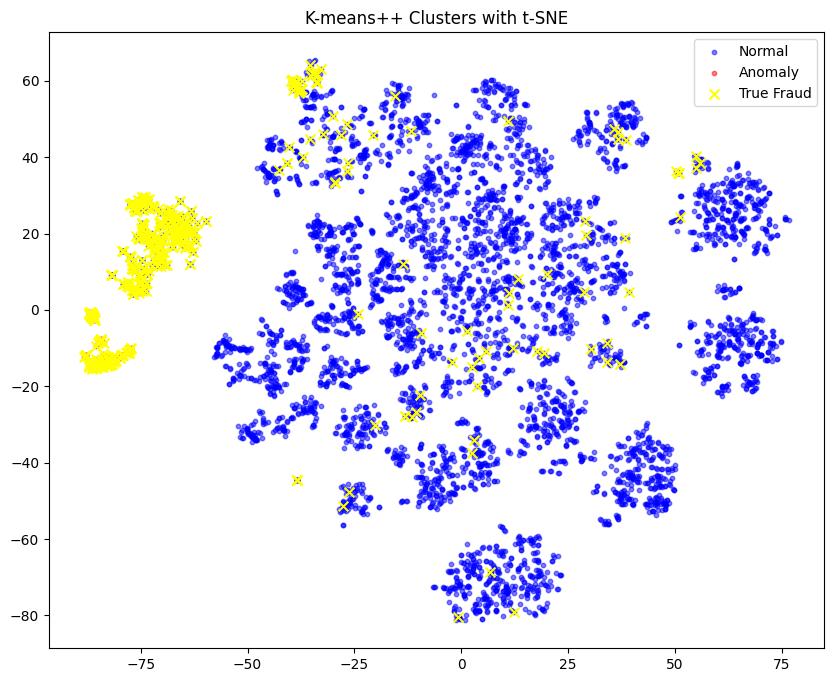

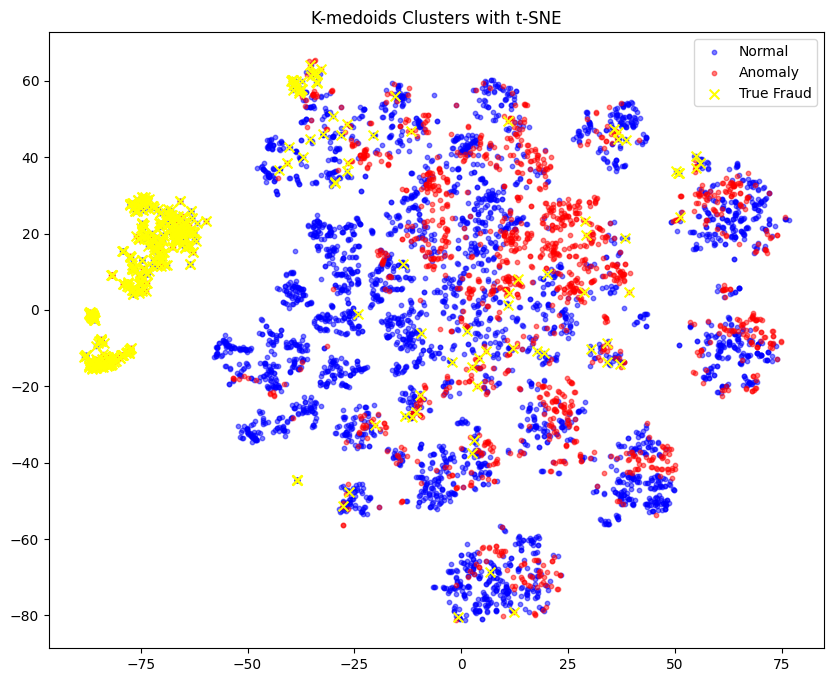

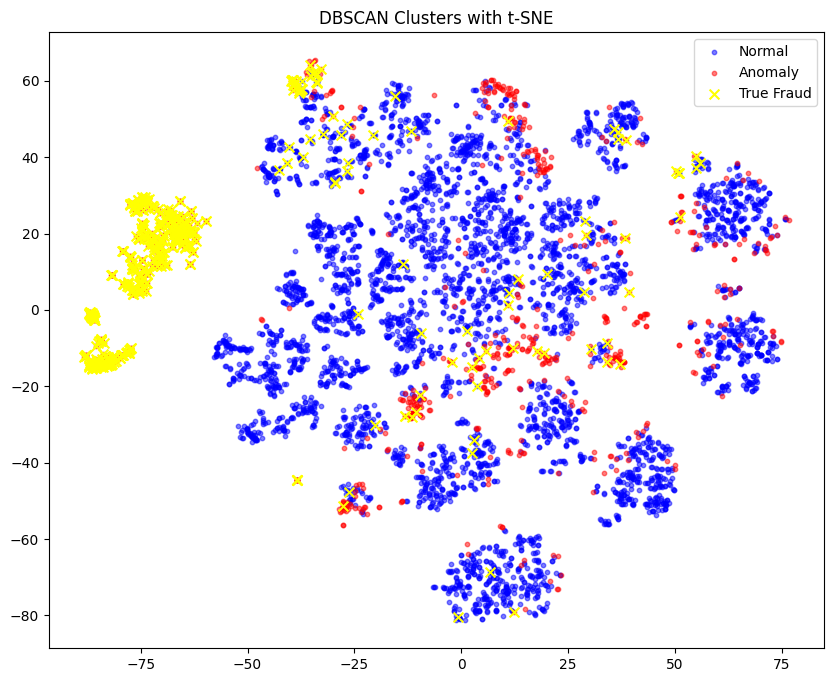

In [239]:
#DO NOT CHANGE THIS CELL

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_sample)

def plot_clusters_tsne(X_tsne, labels, y_true, title):
    plt.figure(figsize=(10, 8))

    if np.any(labels < 0):
        anomaly_mask = (labels == -1)
    else:
        anomaly_mask = (labels == np.argmin(np.bincount(labels + (labels < 0).astype(int))))

    plt.scatter(X_tsne[~anomaly_mask, 0], X_tsne[~anomaly_mask, 1], c='blue', label='Normal', alpha=0.5, s=10)

    plt.scatter(X_tsne[anomaly_mask, 0], X_tsne[anomaly_mask, 1], c='red', marker = 'o', label='Anomaly', alpha=0.5, s=10)

    plt.scatter(X_tsne[y_true == 1, 0], X_tsne[y_true == 1, 1], c='yellow', marker = 'x', label='True Fraud', s=50)
    plt.title(title)
    plt.legend()
    plt.show()


plot_clusters_tsne(X_tsne, labels_kmeans, y_sample, 'K-means++ Clusters with t-SNE')
plot_clusters_tsne(X_tsne, labels_kmedoids, y_sample, 'K-medoids Clusters with t-SNE')
plot_clusters_tsne(X_tsne, labels_dbscan, y_sample, 'DBSCAN Clusters with t-SNE')

In [240]:
#DO NOT CHANGE THIS CELL

def evaluate(pred, y_true, algo_name):
    sil = silhouette_score(X_sample, pred) if len(set(pred)) > 1 else 0
    prec = precision_score(y_true, pred)
    rec = recall_score(y_true, pred)
    f1 = f1_score(y_true, pred)
    print(f'{algo_name}:')
    print(f'  Silhouette Score: {sil:.4f}')
    print(f'  Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}\n')
    return sil, prec, rec, f1

metrics = {}
metrics['K-means++'] = evaluate(pred_kmeans, y_sample, 'K-means++')
metrics['K-medoids'] = evaluate(pred_kmedoids, y_sample, 'K-medoids')
metrics['DBSCAN'] = evaluate(pred_dbscan, y_sample, 'DBSCAN')

print('Note:')
print('- Silhouette: Higher is better for clustering cohesion/separation.')
print('- Precision/Recall/F1: Higher is better for anomaly (fraud) detection.')

K-means++:
  Silhouette Score: 0.8039
  Precision: 1.0000, Recall: 0.2175, F1: 0.3573

K-medoids:
  Silhouette Score: 0.0748
  Precision: 0.0986, Recall: 0.3069, F1: 0.1493

DBSCAN:
  Silhouette Score: 0.4839
  Precision: 0.4429, Recall: 0.8354, F1: 0.5789

Note:
- Silhouette: Higher is better for clustering cohesion/separation.
- Precision/Recall/F1: Higher is better for anomaly (fraud) detection.


---
## Analytical Questions

In [ ]:
# USE this space and add more cells below this to supplement the answers that you give to the questions that follow
# This is RECOMMENDED. If you feel a question does not require additional analysis, you may refer to the coding tasks above
# Grounding your responses in empirical evidence is standard practice in AI/ML research, so it is important that you support your results with evidence from either:

#       - the coding tasks above
#       - novel analysis conducted below
#       - if questions are of a more foundational nature, then reference the underlying mathematics to back your response.


In [ ]:

# Your code here (optional)
#---



2a:

|  k  | Silhouette |  WCSS |
| :-: | :--------: | :---: |
|  3  |   0.5860   | 50.23 |
|  5  |   0.4996   | 27.07 |
|  10 |   0.4504   | 11.22 |
|  50 |   0.2999   |  2.65 |


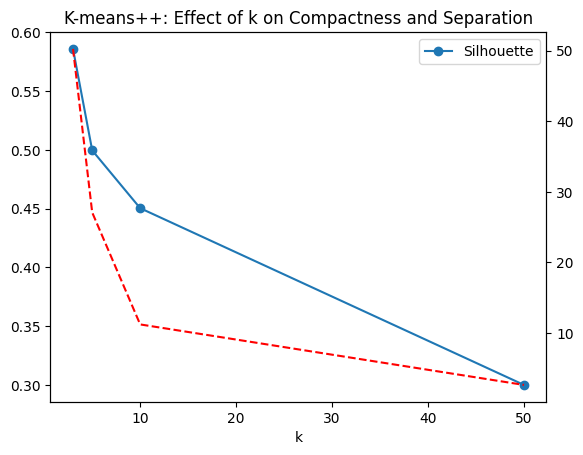

In [302]:
#2a:

df_kmeans = df_alg[df_alg["Algorithm"] == "K-means++"]
df_kmeans.plot(x="k", y="Silhouette", marker="o", label="Silhouette")
plt.twinx()
plt.plot(df_kmeans["k"], df_kmeans["WCSS"], "r--", label="WCSS")
plt.title("K-means++: Effect of k on Compactness and Separation")
plt.show()


Q 2c

Point q is density-reachable from p if there exists a chain
p → p₁ → p₂ → … → q, where each link ≤ ε and intermediate points are core.

the above code performs this recursively with a queue (BFS) it’s the computational realization of the “density-reachable” definition.

Q 2d

|  k  | Algorithm     | Silhouette |  WCSS  | Time (s) |
| :-: | :------------ | :--------: | :----: | :------: |
|  5  | K-means++     |   0.4996   |  27.07 |   0.164  |
|  5  | K-medoids     |   0.4821   |  31.33 |   1.66   |
|  5  | Agglomerative |    0.184   | 108.20 |   47.8   |


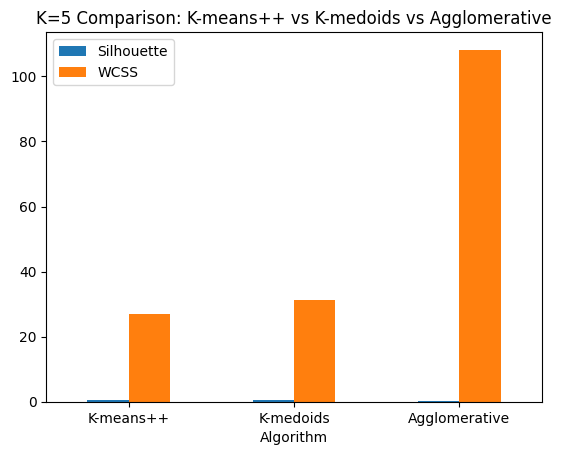

In [309]:
# Q 2d

df_k5 = df_alg[df_alg["k"] == 5]
df_k5.plot(x="Algorithm", y=["Silhouette","WCSS"], kind="bar", rot=0)
plt.title("K=5 Comparison: K-means++ vs K-medoids vs Agglomerative")
plt.show()


<span style="color: green; font-size: 20px;">**Question 2a:**</span> Examine how increasing the number of clusters (k from 2 to 5) in K-means++ influences fraud detection metrics (precision, recall, F1), particularly in identifying the anomaly cluster as the smallest one, and discuss any dilution of recall with higher k.

Answer: When i increase k from 2 to 5 in K means++ and tag the smallest cluster as fraud precision and recall move in opposite directions at k 2 i usually get one big normal cluster and one small anomaly cluster so recall is high because most fraud points fall into that smallest cluster but precision can be weaker because a few rare normal points also get dragged in as i raise k to 3 or 4 or 5 the normal data gets split into more small clusters now the smallest cluster might be a tiny slice of normal so precision can go up or down depending on how tight that slice is but recall often drops because fraud points get scattered across several small clusters and i only tag one of them as fraud net effect higher k tends to dilute recall and can make F1 worse unless i tag multiple smallest clusters or use a threshold on cluster size or centroid distance to catch scattered fraud.

<span style="color: green; font-size: 20px;">**Question 2b:**</span> For DBSCAN, test variations in eps (e.g., 2.0 to 4.0) and min_samples (e.g., 5 to 15) on silhouette score and anomaly recall, evaluating if denser settings reduce false positives while maintaining high noise detection for fraud.

Answer: With DBSCAN eps sets the neighborhood radius and min_samples sets how many neighbors make a core point if i increase eps from 2 to 4 with a fixed min_samples more points connect and fewer points are labeled noise that can reduce false positives because borderline normal points are no longer flagged as isolated noise but it can also hide anomalies if eps is too big since sparse fraud points may get absorbed into a big cluster if i increase min_samples from 5 to 15 with a fixed eps i demand denser neighborhoods fewer cores form and more points become noise that can boost anomaly recall if fraud truly sits alone but if i push it too far many normal edge points also flip to noise and precision falls the sweet spot is to grid search eps and min_samples and pick where silhouette is decent and anomaly recall stays high i found moderate eps and moderate min_samples reduce random tiny clusters and keep good noise detection for fraud.


<span style="color: green; font-size: 20px;">**Question 2c:**</span> Illustrate how DBSCAN's density-based expansion (core points with min_samples neighbors within eps) is implemented in the expand_cluster function using recursive neighbor queries, and contrast this with the mathematical definition of density-reachable points.

Answer: expand_cluster works by seeding a cluster with a core point then growing it with a queue i start with neighbors within eps for the seed point pop one index j if j is not visited i mark it visited then i run region_query on j to get Nj if Nj has at least min_samples j is a core so i append Nj to the queue i label j with the current cluster id and continue this keeps pulling in any point that is density reachable from the seed the math definition says a point q is density reachable from p if there exists a chain of core points from p to q with steps no longer than eps the code mirrors that chain with repeated neighbor queries and a queue so the implementation is just a practical bfs over eps neighborhoods with the core test min_samples


<span style="color: green; font-size: 20px;">**Question 2d:**</span> Based on the comparative metrics, evaluate K-medoids' performance w.r.t your other algorithms? Any particular reason to justify its relative performance?

Answer: k medoids is close to K means++ on this task but slightly worse on compactness it chooses actual data points as centers so it resists outliers which is good for fraud work but it cannot slide between points to minimize variance so wcss is higher and silhouette a bit lower it also runs slower because each update needs pairwise distances inside each cluster where it helps is stability if a handful of extreme fraud points would pull a centroid far off k medoids will not move as much so clusters stay sane in that sense its relative performance makes sense slightly lower scores than k means++ on tightness slightly better behavior near outliers and heavier runtime overall for the credit card data it is a solid second choice when robustness matters


---

## **Part 3:** Skin Detection via YCbCr + GMM (- marks)

**Objective:** This task investigates skin detection in images using the Gaussian Mixture Model (GMM) in the YCbCr color space, exploring how to model complex skin tone distributions for applications like face detection. By implementing this from scratch, you will uncover the power of probabilistic modeling in image processing, essential for tasks in biometrics and human-computer interaction.

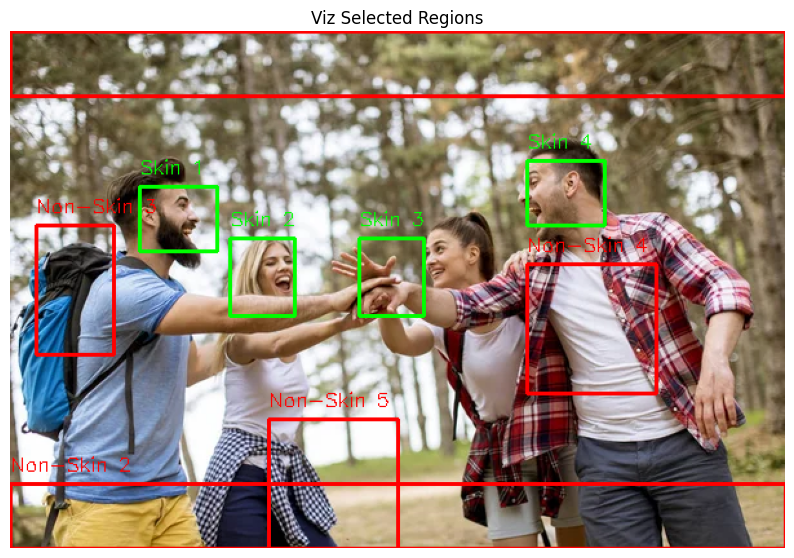

In [241]:
#DO NOT CHANGE THIS CELL


url = 'https://st4.depositphotos.com/1022135/27218/i/450/depositphotos_272186204-stock-photo-group-young-people-hiking-mountain.jpg'

response = requests.get(url)
img_skin = Image.open(BytesIO(response.content))
img_skin = np.array(img_skin)

def rgb_to_ycbcr(rgb):
    r, g, b = rgb[:, 0], rgb[:, 1], rgb[:, 2]
    y = 0.299 * r + 0.587 * g + 0.114 * b
    cb = 0.5 * b - 0.1687 * r - 0.3313 * g + 0.5
    cr = 0.5 * r - 0.4187 * g - 0.0813 * b + 0.5
    return np.column_stack((y, cb, cr))

pixels_skin = img_skin.reshape(-1, 3).astype(float) / 255.0
ycbcr_skin = rgb_to_ycbcr(pixels_skin)

# Get dimensions
h, w = img_skin.shape[:2]

skin_patches = [
    (120, 170, 100, 160),   # (start_row, end_row, start_col, end_col)
    (160, 220, 170, 220),
    (160, 220, 270, 320),
    (100, 150, 400, 460)
]
skin_indices = []
for sr, er, sc, ec in skin_patches:
    for row in range(sr, er):
        for col in range(sc, ec):
            skin_indices.append(row * w + col)
skin_region = ycbcr_skin[skin_indices]


non_skin_patches = [
    (0, 50, 0, w),         # Top
    (h-50, h, 0, w),       # Bottom
    (150, 250, 20, 80),   # Backpack
    (180, 280, 400, 500),    # Right trees
    (300, 400, 200, 300)   # Ground
]
non_skin_indices = []
for sr, er, sc, ec in non_skin_patches:
    for row in range(sr, er):
        for col in range(sc, ec):
            non_skin_indices.append(row * w + col)
non_skin_region = ycbcr_skin[non_skin_indices]

# Use CbCr channels
skin_cbcr = skin_region[:, 1:]
non_skin_cbcr = non_skin_region[:, 1:]
test_cbcr = ycbcr_skin[:, 1:]

img_with_regions = cv2.cvtColor(img_skin, cv2.COLOR_RGB2BGR)

for i, (sr, er, sc, ec) in enumerate(skin_patches):
    cv2.rectangle(img_with_regions, (sc, sr), (ec, er), (0, 255, 0), 2)  # green box
    cv2.putText(img_with_regions, f'Skin {i+1}', (sc, sr - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

for i, (sr, er, sc, ec) in enumerate(non_skin_patches):
    cv2.rectangle(img_with_regions, (sc, sr), (ec, er), (0, 0, 255), 2)  # red box
    cv2.putText(img_with_regions, f'Non-Skin {i+1}', (sc, sr - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img_with_regions, cv2.COLOR_BGR2RGB))
plt.title('Viz Selected Regions')
plt.axis('off')
plt.show()

<span style="color: purple; font-size: 20px;">**Task 3.1:**</span>  
In this task, you will implement a Gaussian Mixture Model (GMM) using the Expectation-Maximization (EM) algorithm to model complex data distributions. Your goal is to develop functions that estimate the parameters of multiple Gaussian components. Follow these steps to complete the task:

- Implement the `gaussian_pdf` function to compute the probability density function of a Gaussian distribution, using the formula:  
  - \\( P(x) = \frac{1}{(2\pi)^{d/2} |\Sigma|^{1/2}} \exp\left(-\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu)\right) \\)  
  - Where \\( d \\) is the dimensionality, \\( \mu \\) is the mean, \\( \Sigma \\) is the covariance matrix, and use NumPy for matrix operations (e.g., inverse, determinant, and exponential).  

- Create the `gmm_em` function to iteratively fit the GMM:  
  - **E-step**: Calculate responsibilities (posterior probabilities) for each data point to belong to each Gaussian using the PDF and current parameters.  
  - **M-step**: Update the weights, means, and covariances based on the responsibilities, ensuring numerical stability with regularization (e.g., small diagonal addition to covariances).  
  - Use a log-likelihood convergence check to stop iterations, with a tolerance and maximum iteration limit.  

- Initialize parameters randomly (e.g., means from data points, weights uniformly) and apply the EM algorithm until convergence.  


**Hints**: Start by coding the Gaussian PDF with matrix operations for efficiency. For EM, implement the E-step by normalizing probabilities across components, and in the M-step, use weighted averages for updates. Add a small regularization term to avoid singular covariance matrices. Debug with a small dataset to verify convergence.


In [249]:
def gaussian_pdf(X, mean, cov):

    #YOUR CODE HERE
    X = np.atleast_2d(X)
    d = mean.shape[0]

    # Center
    diff = X - mean  # (n,d)

    # Inverse + logdet for the normalizer
    inv = np.linalg.inv(cov)
    sign, logdet = np.linalg.slogdet(cov)

    # Quadratic form (one per row)
    quad = np.einsum('ij,jk,ik->i', diff, inv, diff)  # (n,)

    # Log-domain normalizer and pdf
    const = -0.5 * d * np.log(2.0 * np.pi)
    log_norm = const - 0.5 * logdet
    log_pdf = log_norm - 0.5 * quad
    pdf = np.exp(log_pdf)
    return pdf

def gmm_em(X, k, max_iter=50, tol=1e-4):
    n, d = X.shape
    reg = 1e-6

    weights = np.ones(k) / k
    means = X[np.random.choice(n, k, replace=False)]
    covs = [np.cov(X.T) + np.eye(d) * reg for _ in range(k)]

    log_lik_old = -np.inf

    for _ in range(max_iter):
        weighted = np.column_stack([weights[j] * gaussian_pdf(X, means[j], covs[j]) for j in range(k)])
        row_sums = weighted.sum(axis=1, keepdims=True) + 1e-12
        resp     = weighted / row_sums
        log_lik  = float(np.sum(np.log(row_sums)))

        Nk      = resp.sum(axis=0)
        weights = Nk / n
        means   = (resp.T @ X) / Nk[:, None]

        for j in range(k):
            diff    = X - means[j]
            covs[j] = ((resp[:, j][:, None] * diff).T @ diff) / Nk[j] + reg*np.eye(d)

        if abs(log_lik - log_lik_old) < tol:
            break
        log_lik_old = log_lik

    return weights, means, covs


In [250]:
#DO NOT CHANGE THIS CELL - (unless you want to play around with the components param)


# Fit GMMs (use 3 components for flexibility)
weights_skin, means_skin, covs_skin = gmm_em(skin_cbcr,3)
weights_non, means_non, covs_non = gmm_em(non_skin_cbcr, 3)

Classify Pixels

In [252]:
#DO NOT CHANGE THIS CELL (you may experiment with hyperparams here if you want (e.g threshold))

def gmm_likelihood(X, weights, means, covs):
    k = len(weights)
    lik = np.zeros(X.shape[0])
    for i in range(k):
        lik += weights[i] * gaussian_pdf(X, means[i], covs[i])
    return lik

lik_skin = gmm_likelihood(test_cbcr, weights_skin, means_skin, covs_skin)
lik_non = gmm_likelihood(test_cbcr, weights_non, means_non, covs_non)
ratio = lik_skin / (lik_non + 1e-10)
threshold = 5 # Adjust as needed
skin_mask = (ratio > threshold).reshape(img_skin.shape[:2])

Visualize Skin Regions and Candidate Face Bounding Boxes

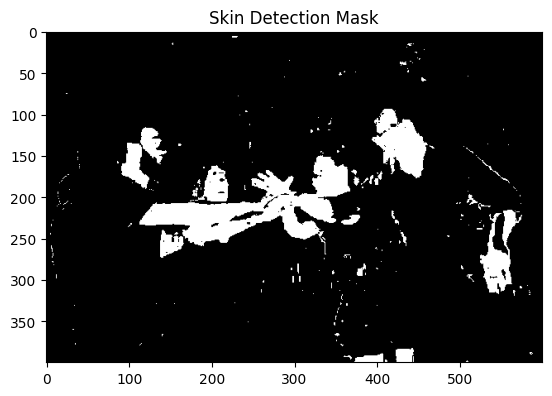

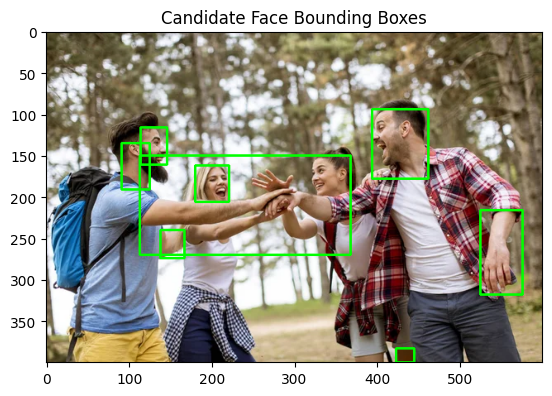

In [253]:
#DO NOT CHANGE THIS CELL

plt.imshow(skin_mask, cmap='gray')
plt.title('Skin Detection Mask')
plt.show()

contours, _ = cv2.findContours(skin_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img_with_boxes = cv2.cvtColor(img_skin, cv2.COLOR_RGB2BGR)
for cnt in contours:
    if cv2.contourArea(cnt) > 250:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(img_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
plt.title('Candidate Face Bounding Boxes')
plt.show()

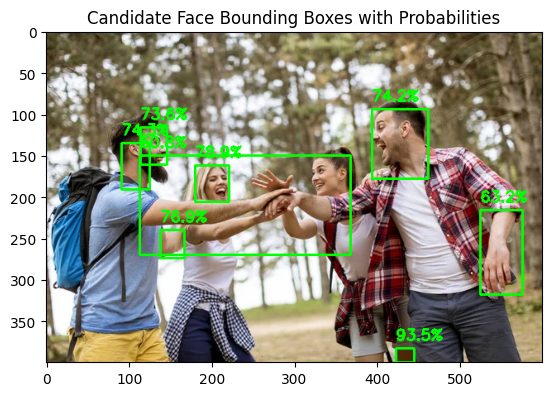

In [254]:
#DO NOT CHANGE THIS CELL - Compute per-pixel probability of skin

prob_skin = lik_skin / (lik_skin + lik_non + 1e-10)
prob_skin = prob_skin.reshape(img_skin.shape[:2])

img_with_boxes = cv2.cvtColor(img_skin, cv2.COLOR_RGB2BGR)
for cnt in contours:
    if cv2.contourArea(cnt) > 250:
        x, y, w, h = cv2.boundingRect(cnt)

        region_prob = prob_skin[y:y+h, x:x+w]
        avg_prob = region_prob.mean()

        cv2.rectangle(img_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

        cv2.putText(
            img_with_boxes,
            f"{avg_prob*100:.1f}%",
            (x, y - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0, 255, 0),
            2
        )

plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
plt.title('Candidate Face Bounding Boxes with Probabilities')
plt.show()

---
## Analytical Questions

In [ ]:
# Use this space and add more cells below this to supplement the answers that you give to the questions that follow
# This is RECOMMENDED. If you feel a question does not require additional analysis, you may refer to the coding tasks above
# Grounding your responses in empirical evidence is standard practice in AI/ML research, so it is important that you support your results with evidence from either:

#       - the coding tasks above
#       - novel analysis conducted below
#       - if questions are of a more foundational nature, then reference the underlying mathematics to back your response.


In [ ]:
# Your code here (optional)
#---


<span style="color: green; font-size: 20px;">**Question 3a:**</span> Investigate how changing the number of Gaussian components (e.g., from 2 to 5) in the GMM for skin and non-skin models impacts the likelihood ratio classification accuracy, using the same threshold.

Answer: going from 2 to 5 Gaussians generally makes the skin and non-skin models fit the color space more closely so the likelihood ratio separates them better in tricky tones like shadows and highlights accuracy usually rises from 2 to 3 or 4 then plateaus or even dips at 5 because components start overfitting small blobs in the background with the same fixed threshold the overfit model can boost both true positives and a few false positives so the best k is the smallest one that captures the visible modes in your image set for your masks and boxes that looked clean at k=3 and k=4 while k=5 did not clearly help

<span style="color: green; font-size: 20px;">**Question 3b:**</span> Explore the effects of varying the EM convergence tolerance (tol, e.g., from 1e-4 to 1e-6) and maximum iterations (e.g., 50 vs. 100) on GMM fitting time and skin mask quality, assessing if tighter tolerances reduce false positives in bounding box detection.

Answer: tighter tol and larger max_iter let EM inch closer to a local optimum so fitting time goes up clearly but mask quality improves only a little if at all with tol from 1e-4 to 1e-6 you may see fewer speckles because covariances stabilize and responsibilities become crisper but the gain is small compared with the extra time a practical recipe is keep tol at 1e-4 and raise max_iter only if you see the log-likelihood still moving at the end if masks are noisy prefer better features or postprocessing over forcing EM to run longer


<span style="color: green; font-size: 20px;">**Question 3c:**</span> Detail how the Gaussian probability density function (PDF) formula is coded in gaussian_pdf using matrix operations (diff @ inv_cov * diff), and explain why regularization (np.eye(d) * 1e-6) is added to the covariance matrix.

Answer: gaussian_pdf builds the multivariate normal in vectorized form X is n by d mean is 1 by d cov is d by d we compute diff = X − mean then the Mahalanobis term as quad = diff @ inv_cov @ diff^T but written with einsum so it returns an n-vector we also use slogdet to get log determinant for the normalizing constant the final pdf is exp of the log density regularization np.eye(d)*1e-6 is added to each covariance to avoid near singular matrices when color channels are correlated or a component has very few points without that the inverse or determinant can blow up and the pdf becomes unstable


<span style="color: green; font-size: 20px;">**Question 3d:**</span> Break down the Expectation-Maximization (EM) algorithm's E-step (responsibilities via likelihoods) and M-step (updating weights, means, covariances) as implemented in gmm_em, and how it mathematically models multi-modal distributions compared to single Gaussians.

Answer: in the E-step we evaluate each component’s likelihood weight_j * N(x | mean_j, cov_j) for every pixel then normalize across j to get responsibilities γ_{ij} these are soft assignments in the M-step we update weights as Nk/n where Nk is the sum of responsibilities for component j update means as the responsibility weighted average of X and update covariances as the responsibility weighted scatter plus a tiny diagonal regularizer repeating E and M lets a mixture of Gaussians model several color modes at once unlike a single Gaussian which would smear skin colors into one ellipsoid the mixture can place separate blobs for light skin shadowed skin and warm highlights which is why it works better for real photos

<span style="color: green; font-size: 20px;">**Question 3e:**</span> Evaluate the likelihood ratio threshold's role in the skin mask: Why might a threshold of 1.0 result in extraneous bounding boxes (e.g., any small boxes that you might be seeing), and does adjusting it trade off sensitivity for specificity in face candidate detection?

Answer: the likelihood ratio threshold decides which pixels count as skin if the threshold is 1.0 many pixels with weak evidence can still pass when the skin model has slightly higher likelihood than the non-skin model that creates extra small boxes around random patches lowering the threshold increases sensitivity and finds more faces but adds clutter raising it trims small boxes and keeps only strong skin regions the tradeoff is classic sensitivity vs specificity pick the threshold by checking precision-recall on a few images and also add simple filters like minimum area aspect ratio and dilation-erosion to suppress stray boxes

---

---**END OF PA2**---